# Mongo collections analysis

## Init

In [12]:
import pymongo, math, json, ast, datetime, time, os
import matplotlib.pyplot as plt
from matplotlib import colormaps
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from scipy.stats import entropy
from tqdm import tqdm

from config import Config

image_version = "2.2.3"
base_image_path = f"images/mongo_analysis/v{image_version}"
if f"v{image_version}" not in os.listdir("images/mongo_analysis"):
    os.mkdir(base_image_path)

image_path = f"images/mongo_analysis/v{image_version}"

def set_image_subpath(subpath):
    global image_path
    image_path = f"{base_image_path}/{subpath}"
    if subpath not in os.listdir(base_image_path):
        os.mkdir(image_path)
        

In [13]:
image_path

'images/mongo_analysis/v2.2.3'

In [14]:
# MongoDB connection settings (replace placeholders with your actual MongoDB connection details)
client = pymongo.MongoClient(Config.MONGO_URI)
db = client[Config.MONGO_DB]
benign = db.benign_2310
misp = db.misp_2311

### TODO

Lexikální
- [x] Histogram výskytů různých TLD
- [x] průměrná délka domény
- [x] průměrná entropie
- [x] Průměrný výskyt jednotlivých skupin znaků (písmenka, čísla, hex, ...)
- [x] Průměrná délka nejkratší, nejdelší, a průměrné části domény
- [x] Průměrný počet subdomén
- [x] Nejtypičtější bigramy a trigramy

IP
- [x]  informace o IP adresách, takže třeba kolik je průměrně IPv4 a IPv6 adres atd

DNS
- [ ] a počty záznamy různých ty
- [ ] o jak se tam pohybují ty ttl hodno
- [ ] y 
Hodně nám tam dominovala ta tls_root_cert_lifeti
- [ ] .. tak se třeba podívat, jak se to pohybuje u phishingových a benign
- [ ] .. jaká je doba platnosi (validity_e
 GEO
- x ] z jakých kontinent
- x ] z jakých  zemí ty domény jso.

## Domain

In [15]:
set_image_subpath("lexical")

#### Fetch data from MongoDB

In [16]:
tlds_benign = list(benign.find({}, {'domain_name': 1}))
tlds_misp = list(misp.find({}, {'domain_name': 1}))

### TLDs

#### Definitions

In [17]:
image_path

'images/mongo_analysis/v2.2.3/lexical'

In [18]:
def calculate_column_distribution(df, column, min_percentage):
    # Calculate the normalized counts of each column value
    values_counts = df[column].value_counts(normalize=True)
    # Filter column values based on the minimum percentage
    filtered_values = values_counts[values_counts >= min_percentage]
    filtered_values = round(filtered_values * 100, 2)
    # Calculate the sum of counts for column values below the threshold
    others_count = round(values_counts[values_counts < min_percentage].sum() * 100, 2)

    value_names, values_counts = zip(*list(filtered_values.items())+[("Other", others_count)])
    # Return the column values distribution
    return pd.DataFrame(data={
        "name": value_names,
        "count": values_counts
    })


def barplot_column_distribution(df, feature, name, **kwargs):
    plt.figure(figsize=(12, 8))
    horizontal = kwargs.get("orient") == 'h' 
    
    ax = sns.barplot(x="count", y="name", data=df, saturation=0.6, label=name, **kwargs)

    get_yticklabels = ax.get_xticklabels if horizontal else ax.get_yticklabels
    set_yticklabels = ax.set_xticklabels if horizontal else ax.set_yticklabels
    xlabel = plt.ylabel if horizontal else plt.xlabel
    ylabel = plt.xlabel if horizontal else plt.ylabel

    xlabel(feature)
    
    # Apply logarithmic scale if log_scale is True
    if kwargs.get("log_scale"):
        yticks_labels = [f"{pow(10, x-1)}%" for x in range(len(get_yticklabels()))]
        set_yticklabels(yticks_labels)
        ylabel(f'Percentage (log)')
    else:
        yticks_labels = [f"{x.get_text()}%" for x in get_yticklabels()]
        set_yticklabels(yticks_labels)
        ylabel('Percentage')

    plt.xticks(rotation=45)
        
    plt.title(f'{feature}s - {name}')
    ax.bar_label(ax.containers[0])
    plt.tight_layout()
    plt.savefig(f"{image_path}/{feature}s - {name}_barplot.png")
    plt.savefig(f"{image_path}/{feature}s - {name}_barplot.pdf", format='pdf')
    plt.show()



def piechart_column_distribution(df, feature, name, color_map=plt.cm.Reds, legend=False, **kwargs):
    plt.figure(figsize=(12, 10))
    logged = np.log(df['count']*10)/5
    scaled = logged / max(logged) * 0.75
    colors = color_map(scaled)
    # total_size = sum(sizes)
    scaled=[0.5 for x in range(len(df))]
    wedges, texts, autotexts = plt.pie(df['count'], labels=df['name'], autopct='%1.1f%%', startangle=90, pctdistance=0.8)

    if legend:
        plt.legend(wedges, df['name'], title=f"{feature}s", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
        # Hide labels around the circle
        for text in texts:
            text.set_visible(False)

    plt.title(f'{feature}s - {name}')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    # plt.tight_layout()
    if legend:
        plt.savefig(f"{image_path}/{feature}s - {name}_piechart_w_legend.png")
        plt.savefig(f"{image_path}/{feature}s - {name}_piechart_w_legend.pdf", format="pdf")
    else:
        plt.savefig(f"{image_path}/{feature}s - {name}_piechart.png")
        plt.savefig(f"{image_path}/{feature}s - {name}_piechart.pdf", format="pdf")

    plt.show()


# Author: Radek Hranický
def piechart_column_distribution3(df, feature, name, color_map=plt.cm.tab10, legend=False, **kwargs):
    plt.figure(figsize=(10, 8))
    
    # Combine two different color maps
    color_map1 = plt.cm.tab20(np.linspace(0., 1., 20))
    color_map2 = plt.cm.tab10(np.linspace(0., 1., 12))  # tab10 has 12 distinct colors
    combined_colors = np.vstack((color_map1, color_map2))  # Stack the color maps

    # Assign colors to each category, ensuring 'Other' is set to grey
    colors = [combined_colors[i] if tld != "Other" else 'grey' for i, tld in enumerate(df['name'])]

    # Create the pie chart without autopct
    wedges, texts = plt.pie(df['count'], startangle=90, colors=colors, **kwargs)

    # Calculate the percentages and set up the labels
    percentages = [100. * c / sum(df['count']) for c in df['count']]
    labels = [f"{tld} $\\mathbf{{{pct:.1f}\\%}}$" for tld, pct in zip(df['name'], percentages)]

    # Annotate with TLD and percentage
    for i, (wedge, label) in enumerate(zip(wedges, labels)):
        ang = (wedge.theta2 + wedge.theta1) / 2
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))

        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle),
                  horizontalalignment=horizontalalignment, size=12, va='center')

        plt.annotate(label, xy=(x, y), xytext=(1.5*x, 1.2*y), **kw)

    if legend:
        plt.legend(wedges, df['name'], title=f"{feature}s", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=16)

    plt.title(f'{feature}s - {name}', fontsize=14)
    plt.axis('equal')

    # Adjust the margins and save the figure with enough space for the content
    plt.subplots_adjust(left=0.0, right=0.85, top=0.9, bottom=0.1)  # Adjust as needed
    plt.tight_layout()
    plt.savefig(f"{image_path}/{feature}s_{name}_piechart.png", bbox_inches='tight')
    plt.savefig(f"{image_path}/{feature}s_{name}_piechart.pdf", format='pdf', bbox_inches='tight')

    plt.show()

    
# Author: Radek Hranický
def piechart_column_distribution4(df, feature, name, width=8, height=6, color_map=plt.cm.tab10, title=False, legend=False, **kwargs):
    plt.figure(figsize=(width, height))
    
    # Combine two different color maps
    color_map1 = plt.cm.tab20(np.linspace(0., 1., 20))
    color_map2 = plt.cm.tab10(np.linspace(0., 1., 12))  # tab10 has 12 distinct colors
    combined_colors = np.vstack((color_map1, color_map2))  # Stack the color maps

    # Assign colors to each category, ensuring 'Other' is set to grey
    colors = [combined_colors[i] if tld != "Other" else 'grey' for i, tld in enumerate(df['name'])]

    # Create the pie chart without autopct
    wedges, texts = plt.pie(df['count'], startangle=90, colors=colors, **kwargs)

    # Calculate the percentages and set up the labels
    percentages = [100. * c / sum(df['count']) for c in df['count']]
    labels = [f"{tld} (${{{pct:.1f}\\%}}$)" for tld, pct in zip(df['name'], percentages)]

    # Annotate with TLD and percentage
    for i, (wedge, label) in enumerate(zip(wedges, labels)):
        ang = (wedge.theta2 + wedge.theta1) / 2
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))

        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle),
                  horizontalalignment=horizontalalignment, size=12, va='center')

        plt.annotate(label, xy=(x, y), xytext=(1.5*x, 1.2*y), **kw)

        # Write percentage inside the pie part if angle is above 10 degrees, adjust position further from the center
        angle_span = wedge.theta2 - wedge.theta1
        if angle_span > 10:
            plt.text(wedge.center[0] + x / 1.3, wedge.center[1] + y / 1.3, f"{percentages[i]:.1f}%", color='white', ha='center', va='center', fontsize=12)

    if legend:
        plt.legend(wedges, df['name'], title=f"{feature}s", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=16)

    if title:
        plt.title(f'{feature}s - {name}', fontsize=14)
    plt.axis('equal')

    # Adjust the margins and save the figure with enough space for the content
    plt.subplots_adjust(left=0.0, right=0.85, top=0.9, bottom=0.1)  # Adjust as needed
    plt.tight_layout()
    plt.savefig(f"{image_path}/{feature}s_{name}_piechart.png", bbox_inches='tight')
    plt.savefig(f"{image_path}/{feature}s_{name}_piechart.pdf", format='pdf', bbox_inches='tight')

    plt.show()

    
    
# Author: Radek Hranický
def piechart_column_distribution5(df, feature, name, width=8, height=6, color_map=plt.cm.tab10, title=False, legend=False, **kwargs):
    plt.figure(figsize=(width, height))
    
    # Combine two different color maps
    color_map1 = plt.cm.tab20(np.linspace(0., 1., 20))
    color_map2 = plt.cm.tab10(np.linspace(0., 1., 12))  # tab10 has 12 distinct colors
    combined_colors = np.vstack((color_map1, color_map2))  # Stack the color maps

    # Assign colors to each category, ensuring 'Other' is set to grey
    colors = [combined_colors[i] if tld != "Other" else 'grey' for i, tld in enumerate(df['name'])]

    # Create the pie chart
    wedges, texts = plt.pie(df['count'], startangle=90, colors=colors, **kwargs)

    # Calculate the percentages and set up the labels
    percentages = [100. * c / sum(df['count']) for c in df['count']]
    labels = [f"{tld} (${{{pct:.1f}\\%}}$)" for tld, pct in zip(df['name'], percentages)]

    # Initialize a list to store the label positions to check for overlaps
    label_positions = []

    # Annotate with TLD and percentage
    for i, (wedge, label) in enumerate(zip(wedges, labels)):
        ang = (wedge.theta2 + wedge.theta1) / 2
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))
        
        # Default starting position for the label
        label_x = 1.5 * x
        label_y = 1.2 * y
        
        # Adjust label position if it's too close to the previous label
        while any(np.sqrt((label_x - pos[0])**2 + (label_y - pos[1])**2) < 0.1 for pos in label_positions):
            label_x *= 1.1
            label_y *= 1.1

        # Store the current label's position
        label_positions.append((label_x, label_y))
        
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle),
                  horizontalalignment=horizontalalignment, size=12, va='center')

        # Annotate label with adjusted position
        plt.annotate(label, xy=(x, y), xytext=(label_x, label_y), **kw)

        # Write percentage inside the pie part if angle is above 10 degrees
        angle_span = wedge.theta2 - wedge.theta1
        if angle_span > 10:
            plt.text(wedge.center[0] + x / 1.3, wedge.center[1] + y / 1.3, f"{percentages[i]:.1f}%", color='white', ha='center', va='center', fontsize=12)

    if legend:
        plt.legend(wedges, df['name'], title=f"{feature}s", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=16)

    if title:
        plt.title(f'{feature}s - {name}', fontsize=14)
    plt.axis('equal')

    # Adjust the margins and save the figure with enough space for the content
    plt.subplots_adjust(left=0.0, right=0.85, top=0.9, bottom=0.1)
    plt.tight_layout()
    plt.savefig(f"{image_path}/{feature}s_{name}_piechart.png", bbox_inches='tight')
    plt.savefig(f"{image_path}/{feature}s_{name}_piechart.pdf", format='pdf', bbox_inches='tight')

    plt.show()



#### Compute the values

In [19]:
# Create DataFrames
df_benign = pd.DataFrame(tlds_benign)
df_misp = pd.DataFrame(tlds_misp)

df_benign["tld"] = df_benign["domain_name"].apply(lambda x: x.split(".")[-1])
df_misp["tld"] = df_misp["domain_name"].apply(lambda x: x.split(".")[-1])


min_percentage_benign = 0.01
min_percentage_misp = 0.01

# Calculate distributions
benign_tld_dist = calculate_column_distribution(df_benign, "tld", min_percentage_benign)
misp_tld_dist = calculate_column_distribution(df_misp, "tld", min_percentage_misp)


In [20]:
logged = np.log(benign_tld_dist['count']*10)/10
logged / max(logged) * 0.75

0    0.750000
1    0.605017
2    0.391875
3    0.338474
4    0.286008
5    0.283954
6    0.587466
Name: count, dtype: float64

#### Plot the results

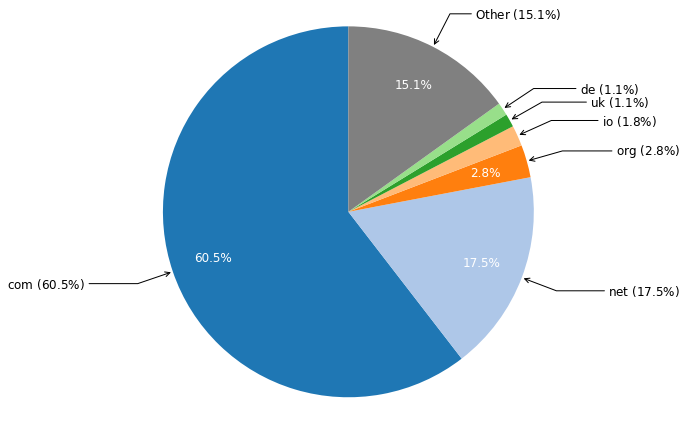

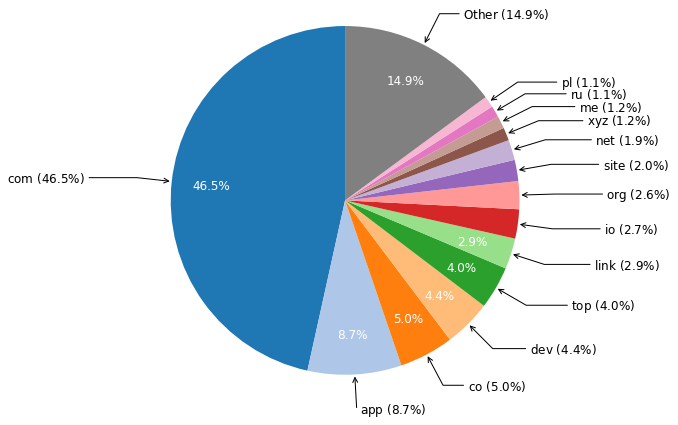

In [21]:
feature_name = "Top-Level Domain"
feature_name = "TLD"

# Plot the Benign data
#barplot_column_distribution(benign_tld_dist, feature_name, "Benign", color="b", log_scale=True, bottom=1e-0)
#piechart_column_distribution(benign_tld_dist, feature_name, "Benign")
#piechart_column_distribution(benign_tld_dist, feature_name, "Benign", legend=True)
#piechart_column_distribution2(benign_tld_dist, feature_name, "Benign")
#piechart_column_distribution3(benign_tld_dist, feature_name, "Benign")
piechart_column_distribution4(benign_tld_dist, feature_name, "Benign")
# Plot the Phishing data
#barplot_column_distribution(misp_tld_dist, feature_name, "Phishing", color="r", log_scale=True, bottom=1e-0)
#piechart_column_distribution(misp_tld_dist, feature_name, "Phishing")
#piechart_column_distribution(misp_tld_dist, feature_name, "Phishing", legend=True)
#piechart_column_distribution3(misp_tld_dist, feature_name, "Phishing")
piechart_column_distribution4(misp_tld_dist, feature_name, "Phishing")


### Lexical domain analysis (Averages)

#### Definitions

In [22]:
# Functions for domain characteristic calculations
def average_domain_length(domains):
    lengths = [len(domain) for domain in domains]
    return sum(lengths) / len(lengths)

def average_entropy(domains):
    def calculate_entropy(string):
        prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
        return - sum([p * math.log(p) / math.log(2.0) for p in prob])

    entropies = [calculate_entropy(domain) for domain in domains]
    return sum(entropies) / len(entropies)

def average_char_groups(domains):
    letter_count = 0
    number_count = 0
    hex_count = 0
    other_count = 0

    for domain in domains:
        for char in domain:
            if char.isalpha():
                letter_count += 1
                if char in ['a', 'b', 'c', 'd', 'e', 'f', 'A', 'B', 'C', 'D', 'E', 'F']:
                    hex_count += 1
            elif char.isdigit():
                number_count += 1
                hex_count += 1
            else:
                other_count += 1

    total_chars = letter_count + number_count + other_count
    return {
        'letters': letter_count / total_chars,
        'numbers': number_count / total_chars,
        'hex': hex_count / total_chars,
        'other': other_count / total_chars
    }

def average_shortest_part_length(domains):
    domain_parts = [domain.split('.') for domain in domains]
    shortest_parts = [min(parts, key=len) for parts in domain_parts]
    return sum(len(part) for part in shortest_parts) / len(shortest_parts)


def average_longest_part_length(domains):
    domain_parts = [domain.split('.') for domain in domains]
    longest_parts = [max(parts, key=len) for parts in domain_parts]
    return sum(len(part) for part in longest_parts) / len(longest_parts)


def average_average_part_length(domains):
    domain_parts = [domain.split('.') for domain in domains]
    avg_lengths = [sum(len(part) for part in parts) / len(parts) if parts else 0 for parts in domain_parts]
    return sum(avg_lengths) / len(avg_lengths) if avg_lengths else 0


def average_subdomains_count(domains):
    subdomain_count = [domain.count('.') for domain in domains]
    return sum(subdomain_count) / len(subdomain_count)


#### Compute the values

In [124]:
# Fetching domain data from MongoDB collections
print("Fetching data from MongoDB collections...")
benign_domains = [entry['domain_name'] for entry in benign.find({}, {'domain_name': 1})]
misp_domains = [entry['domain_name'] for entry in misp.find({}, {'domain_name': 1})]

# Calculate domain characteristics
print("Calculating domain characteristics...")


benign_char_groups = average_char_groups(benign_domains)
benign_characteristics = {
    'AVG Length': average_domain_length(benign_domains),
    'AVG Entropy': average_entropy(benign_domains),
    'Letters Appearance': benign_char_groups["letters"],
    'Numbers Appearance': benign_char_groups["numbers"],
    'Hex Appearance': benign_char_groups["hex"],
    'Other Appearance': benign_char_groups["other"],
    'AVG Shortest Part Len': average_shortest_part_length(benign_domains),
    'AVG Longest Part Len': average_longest_part_length(benign_domains),
    'AVG Average Part Len': average_average_part_length(benign_domains),
    'AVG Subdomain Count': average_subdomains_count(benign_domains)
}

misp_char_groups = average_char_groups(misp_domains)
misp_characteristics = {
    'AVG Length': average_domain_length(misp_domains),
    'AVG Entropy': average_entropy(misp_domains),
    'Letters Appearance': misp_char_groups["letters"],
    'Numbers Appearance': misp_char_groups["numbers"],
    'Hex Appearance': misp_char_groups["hex"],
    'Other Appearance': misp_char_groups["other"],
    'AVG Shortest Part Len': average_shortest_part_length(misp_domains),
    'AVG Longest Part Len': average_longest_part_length(misp_domains),
    'AVG Average Part Len': average_average_part_length(misp_domains),
    'AVG Subdomain Count': average_subdomains_count(misp_domains)
}

# Print domain characteristics for each collection
print("\nBenign Characteristics:")
for key, value in benign_characteristics.items():
    print(f"{key}: {round(value, 5)}")
print("\nMISP Characteristics:")
for key, value in misp_characteristics.items():
    print(f"{key}: {round(value, 5)}")


Fetching data from MongoDB collections...
Calculating domain characteristics...

Benign Characteristics:
AVG Length: 22.24783
AVG Entropy: 3.53636
Letters Appearance: 0.81972
Numbers Appearance: 0.0516
Hex Appearance: 0.31798
Other Appearance: 0.12867
AVG Shortest Part Len: 2.71471
AVG Longest Part Len: 10.65587
AVG Average Part Len: 6.12801
AVG Subdomain Count: 2.26015

MISP Characteristics:
AVG Length: 29.35377
AVG Entropy: 3.8134
Letters Appearance: 0.79232
Numbers Appearance: 0.10952
Hex Appearance: 0.38137
Other Appearance: 0.09816
AVG Shortest Part Len: 2.84886
AVG Longest Part Len: 17.33266
AVG Average Part Len: 8.65148
AVG Subdomain Count: 2.10735


#### Plot the results

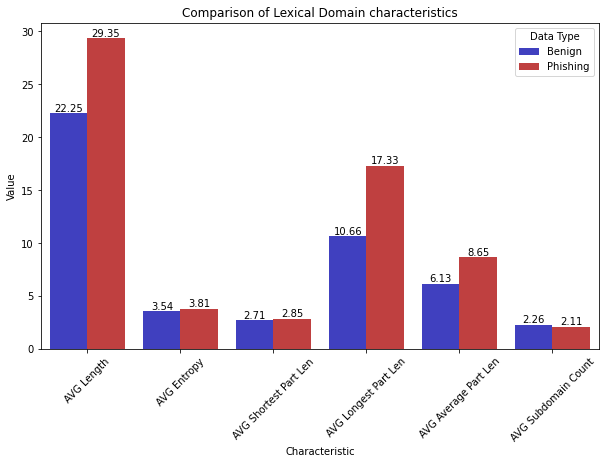

/tmp/ipykernel_81590/1081543035.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks_labels)


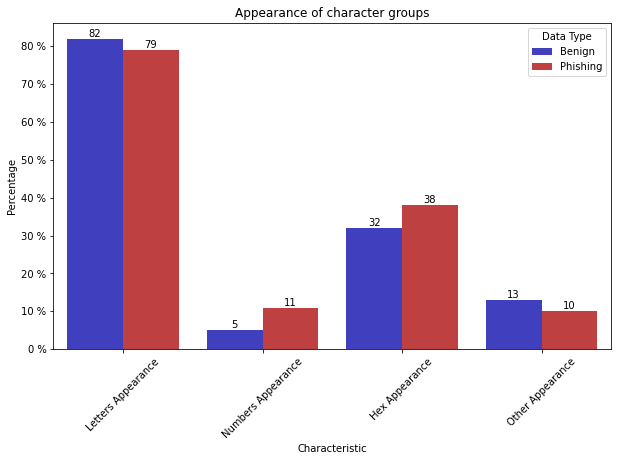

In [13]:
# Visualize the comparison
data_avg = {
    'Characteristic': [],
    'Benign': [],
    'Phishing': []
}

data_appearance = {
    'Characteristic': [],
    'Benign': [],
    'Phishing': []
}

for characteristic in benign_characteristics:
    data = data_avg if "AVG" in characteristic else data_appearance
    data['Characteristic'].append(characteristic)
    data['Benign'].append(round(benign_characteristics[characteristic], 2))
    data['Phishing'].append(round(misp_characteristics[characteristic], 2))

for data, percentages, title in (
    (data_avg, False, "Comparison of Lexical Domain characteristics"), 
    (data_appearance, True, "Appearance of character groups")
):
    # Convert to DataFrame
    df = pd.DataFrame(data)

    if percentages:
        df['Benign'] = df['Benign'] * 100
        df['Phishing'] = df['Phishing'] * 100
    
    # Melt the DataFrame for better visualization
    df_melted = df.melt('Characteristic', var_name='Data Type', value_name='Value')
    
    # Plotting
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Characteristic', y='Value', hue='Data Type', data=df_melted, palette={'Benign': 'blue', 'Phishing': 'red'}, saturation=0.5)
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    plt.title(title)
    plt.xticks(rotation=45)

    if percentages:
        plt.ylabel('Percentage')
        yticks_labels = [label.get_text() + " %" for label in ax.get_yticklabels()]
        ax.set_yticklabels(yticks_labels)

    plt.savefig(f"{image_path}/{title}_barplot.png")
    plt.show()

### Lexical domain analysis (Bigrams, Trigrams)

#### Init & definitions

In [14]:
from nltk import ngrams
import nltk
nltk.download('punkt') #   <----- RUN ONLY ONCE

[nltk_data] Downloading package punkt to /home/ihranicky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
def get_ngrams(domains, n):
    all_ngrams = []
    for domain in domains:
        tokens = nltk.word_tokenize(domain)
        n_grams = ngrams(tokens, n)
        all_ngrams.extend(n_grams)
    return all_ngrams

#### Compute and Plot the values

In [16]:
# Get bigrams and trigrams from the domain names
benign_bigrams = get_ngrams(benign_domains, 2)
misp_bigrams = get_ngrams(misp_domains, 2)

benign_trigrams = get_ngrams(benign_domains, 3)
misp_trigrams = get_ngrams(misp_domains, 3)

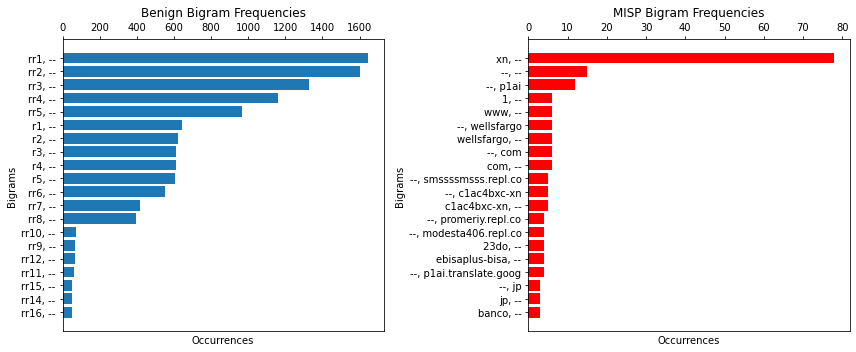

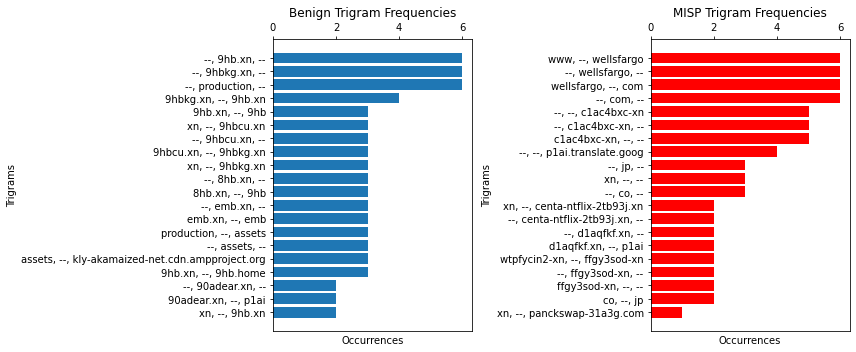

In [17]:
def plot_top_n_n_grams(benign_n_grams, misp_n_grams, top_n=20, ylabel=""):
    # Sort the bigrams by least common for both datasets
    counter_benign_bigrams = Counter(benign_n_grams).most_common(top_n)
    counter_misp_bigrams = Counter(misp_n_grams).most_common(top_n)
    
    total_benign_top_n = sum(count for _, count in counter_benign_bigrams)
    total_misp_top_n = sum(count for _, count in counter_misp_bigrams)
    
    total_benign_counts = len(benign_bigrams)
    total_misp_counts = len(misp_bigrams)
    
    # Extract bigram labels and counts for plotting
    benign_labels, benign_counts = zip(
        *reversed(counter_benign_bigrams)
    )
    misp_labels, misp_counts = zip(
        *reversed(counter_misp_bigrams)
    )
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.barh([", ".join(x) for x in benign_labels], benign_counts)
    plt.title(f'Benign {ylabel} Frequencies')
    plt.ylabel(ylabel+'s')
    plt.xlabel('Occurrences')
    plt.gca().xaxis.tick_top()
    
    plt.subplot(1, 2, 2)
    plt.barh([", ".join(x) for x in misp_labels], misp_counts, color="r")
    plt.title(f'MISP {ylabel} Frequencies')
    plt.ylabel(ylabel+'s')
    plt.xlabel('Occurrences')
    plt.gca().xaxis.tick_top()
    
    plt.tight_layout()
    plt.show()


plot_top_n_n_grams(benign_bigrams, misp_bigrams, ylabel="Bigram")
plot_top_n_n_grams(benign_trigrams, misp_trigrams, ylabel="Trigram")


## IP

### Data init

#### Definitions (run all)

In [18]:
set_image_subpath("ip")

# WARNING! FUNCTION EXECUTES CODE!!!! 
# ONLY USE ON CSV FILES YOU KNOW ARE SAFE
def load_csv_dumped_column(x):
    if type(x) is list or type(x) is str:
        # because of the datetime, literal_eval throws an error 
        return eval(x)
    return None

def prepare_column_data(df, column):
    # Explode the ip_data column
    df["og_id"] = df["_id"]
    df = df.explode(column)
    df = df.dropna(subset=[column])

    # Flatten the column
    flattened = pd.json_normalize(df[column])
    flattened.reset_index(drop=True, inplace=True)
    
    # Create new IDs
    new_ids = range(len(flattened))
    
    # Map new IDs to original IDs
    id_mapping = dict(zip(new_ids, df["og_id"]))
    flattened["_id"] = flattened.index.map(id_mapping)

    # Join the flattened column with the original DataFrame
    df = df.join(flattened, rsuffix='_flattened')

    return df

In [20]:
# run to save ip loaded and processed datasets
def save_ip_data(benign_ips, misp_ips, w_benign_ips, w_misp_ips):
    benign_ips.to_csv('analysis_data/mongo/benign_ips.csv', index=False)
    misp_ips.to_csv('analysis_data/mongo/misp_ips.csv', index=False)
    w_misp_ips.to_csv('analysis_data/mongo/w_misp_ips.csv', index=False)
    w_benign_ips.to_csv('analysis_data/mongo/w_benign_ips.csv', index=False)

# run to load ip datasets (if there are any)
def load_ip_data():
    benign_ips = pd.read_csv('analysis_data/mongo/benign_ips.csv')
    misp_ips = pd.read_csv('analysis_data/mongo/misp_ips.csv')
    w_misp_ips = pd.read_csv('analysis_data/mongo/w_misp_ips.csv')
    w_benign_ips = pd.read_csv('analysis_data/mongo/w_benign_ips.csv')
    return benign_ips, misp_ips, w_benign_ips, w_misp_ips

#### Load cached data from `/analysis_data/mongo/` (if there are any)

In [19]:
import os

if os.exists('analysis_data/mongo/benign_ips.csv'):
    benign_ips, misp_ips, w_benign_ips, w_misp_ips = load_ip_data()
else:
    #benign_ips = pd.DataFrame(list(benign.find({}, {"ip_data": 1}).limit(100_000)))
    benign_ips = pd.DataFrame(list(benign.find({}, {"ip_data": 1})))
    misp_ips = pd.DataFrame(list(misp.find({}, {"ip_data": 1})))
    
    w_benign_ips = benign_ips.sample(frac=0.2)
    w_misp_ips = misp_ips.sample(frac=0.2)

    save_ip_data(benign_ips, misp_ips, w_benign_ips, w_misp_ips)
    save_ip_data(benign_ips, misp_ips, w_benign_ips, w_misp_ips)
#save_ip_data(benign_ips, misp_ips, w_benign_ips, w_misp_ips)

NameError: name 'load_ip_data' is not defined

#### Load and prepare data (if not loaded already in previous block)

Load IP data from MongoDB into DataFrames. **takes a long time**

In [21]:
# Fetch the first 50,000 entries from benign and misp DataFrames
#benign_ips = pd.DataFrame(list(benign.find({}, {"ip_data": 1}).limit(100_000)))
benign_ips = pd.DataFrame(list(benign.find({}, {"ip_data": 1})))
misp_ips = pd.DataFrame(list(misp.find({}, {"ip_data": 1})))
save_ip_data(benign_ips, misp_ips, w_benign_ips, w_misp_ips)

NameError: name 'w_benign_ips' is not defined

In [ ]:
save_ip_data(benign_ips, misp_ips, w_benign_ips, w_misp_ips)

sample a percentage of the datasets to use for development (so test runs don't take ages)

In [22]:
w_benign_ips = benign_ips.sample(frac=0.2)
w_misp_ips = misp_ips.sample(frac=0.2)

transrom the csv strings in 'ip_data' column into python literals. **NOT NEEDED, IF LOADED DIRECTLY FROM DB** 

In [ ]:
w_benign_ips['ip_data'] = w_benign_ips['ip_data'].apply(load_csv_dumped_column)
w_misp_ips['ip_data'] = w_misp_ips['ip_data'].apply(load_csv_dumped_column)

parse and shape the data into suitable form

In [ ]:
w_benign_ips = prepare_column_data(w_benign_ips, "ip_data")
w_misp_ips = prepare_column_data(w_misp_ips, "ip_data")

# at this point it would be suitable to call save_ip_data(benign_ips, misp_ips, w_benign_ips, w_misp_ips)

#### Print out some samples

In [ ]:
print(w_misp_ips.columns)
print(w_misp_ips['ip_data'].iloc[1])

### Analyse IPv4 percentage

#### Definitions

In [16]:
def average_ipv_percentage(source_df, version):
    df = source_df.copy()
    df.dropna(subset=["rdap.ip_version"])
    # Count the occurrences of IPv4 and IPv6 for each ID
    ipv4_ipv6_counts = df.groupby("_id_flattened")["rdap.ip_version"].value_counts().unstack(fill_value=0)

    # Calculate the percentage of IPv4 among the IDs
    ipv4_ipv6_counts["ipv4_percentage"] = (ipv4_ipv6_counts[version] / (ipv4_ipv6_counts[4] + ipv4_ipv6_counts[6]))
    # fillter only IDs, that have total number of IPs > 0
    ipv4_ipv6_mask = (ipv4_ipv6_counts[4] + ipv4_ipv6_counts[6]) > 0
    # apply filter
    ipv4_ipv6_counts = ipv4_ipv6_counts[ipv4_ipv6_mask]
    ipv4_ipv6_counts["ipv4_percentage"].dropna()

    return ipv4_ipv6_counts["ipv4_percentage"]

def distribution_on_n_bins(df, n=10):
    # split into n bins
    bins = pd.cut(df, bins=n, labels=[round(x/n-1, 1) for x in range(n)])
    # get the count in each bin
    bins_counts = bins.value_counts().sort_index()
    # normalize
    return bins_counts / bins_counts.sum()


def dataset_ipv_percentage(source_df, version):
    df = source_df.copy()
    df.dropna(subset="rdap.ip_version")
    # Count the occurrences of IPv4 and IPv6
    ipv4_ipv6_counts = df["rdap.ip_version"].value_counts()
    return ipv4_ipv6_counts[version] / (ipv4_ipv6_counts[4] + ipv4_ipv6_counts[6])

def n_bin_percentage_scale(n):
    return [f"{round((x/n)*100)}-{round(((x+1)/n)*100)}%" for x in range(n)]

#### Calculate the values

In [ ]:
# Calculate values
n_bins = 10

w_benign_ips_avg_ipv4 = average_ipv_percentage(w_benign_ips, 4)
w_benign_ipv4_dist = distribution_on_n_bins(w_benign_ips_avg_ipv4, n_bins)
w_misp_ips_avg_ipv4 = average_ipv_percentage(w_misp_ips, 4)
w_misp_ipv4_dist = distribution_on_n_bins(w_misp_ips_avg_ipv4, n_bins)
dataset_ipv4_percentage_benign = round(dataset_ipv_percentage(w_benign_ips, 4), 3)
dataset_ipv4_percentage_misp = round(dataset_ipv_percentage(w_misp_ips, 4), 3)

w_benign_ips_avg_ipv6 = average_ipv_percentage(w_benign_ips, 6)
w_misp_ips_avg_ipv6 = average_ipv_percentage(w_misp_ips, 6)
dataset_ipv6_percentage_benign = round(dataset_ipv_percentage(w_benign_ips, 6), 3)
dataset_ipv6_percentage_misp = round(dataset_ipv_percentage(w_misp_ips, 6), 3)


#### Plot the results

In [ ]:
# Create a figure with two subplots
def plot_ipv_n_distribution(n, w_benign_dist, w_misp_dist, dataset_percentage_benign, dataset_percentage_misp):
    other_n = 10 - n
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 1]})
    
    df = pd.DataFrame(data={
        "index": n_bin_percentage_scale(n_bins),
        "Benign": w_benign_dist * 100,
        "Phishing": w_misp_dist * 100
    })
    df_melted = df.melt('index', var_name='Data Type', value_name='Value')
    
    # Plotting

    # for some reason, log)scale doesn't work here
    ax = sns.barplot(x='index', y='Value', hue='Data Type', data=df_melted, palette={'Benign': 'blue', 'Phishing': 'red'}, saturation=0.5, ax=axes[0])
    axes[0].set_xlabel(f'Percentage of IPv{n} Addresses Compared to Total Number of Addresses in a Domain')
    axes[0].set_ylabel('Percentage of Domains')
    yticks_labels = [label.get_text() + " %" for label in ax.get_yticklabels()]
    ax.set_yticklabels(yticks_labels)
    axes[0].set_title(f'Distribution of IPv{n} ratios per domain name: Benign vs. Phishing')
    axes[0].legend()
    
    
    # Create a narrow tall plot to the right
    bars = sns.barplot(x=['Benign', 'Phishing'], y=[dataset_percentage_benign, dataset_percentage_misp], hue=['Benign', 'Phishing'], ax=axes[1], palette=['b', 'r'], saturation=0.5, dodge=False, width=0.5)

    
    axes[1].set_ylabel(f'Dataset IPv{n} Percentage')
    # axes[1].set_xlabel('')
    axes[1].set_title(f'IPv{n} Presence (whole dataset)')
    axes[1].set_ylim(0, 100)
    yticks_labels = [label.get_text() + " %" for label in axes[1].get_yticklabels()]
    axes[1].set_yticklabels(yticks_labels)
    axes[1].bar_label(axes[1].containers[0], fontsize=10);
    
    # Add labels to both bars
    for container, label in zip(axes[1].containers, ['Benign', 'Phishing']):
        axes[1].bar_label(container, label=label, fontsize=10)
    
    plt.tight_layout()
    fig.savefig(f"{image_path}/Average IPv{n} Percentage Distribution_barplot.png")
    fig.savefig(f"{image_path}/Average IPv{n} Percentage Distribution_barplot.pdf", format="pdf")
    plt.show()


for n in [4, 6]:
    # calculate the average percentage of IPv{n} addresses in benign and misp
    w_benign_ips_avg = average_ipv_percentage(w_benign_ips, n)
    w_misp_ips_avg = average_ipv_percentage(w_misp_ips, n)
    # calculate the distributions
    w_benign_dist = distribution_on_n_bins(w_benign_ips_avg, n_bins)
    w_misp_dist = distribution_on_n_bins(w_misp_ips_avg, n_bins)
    # calculate the percentage of IPv{n} addresses on whole benign and misp datasets
    dataset_percentage_benign = round(dataset_ipv_percentage(w_benign_ips, n) * 100, 3)
    dataset_percentage_misp = round(dataset_ipv_percentage(w_misp_ips, n) * 100, 3)
    # plot the result
    plot_ipv_n_distribution(n, w_benign_dist, w_misp_dist, dataset_percentage_benign, dataset_percentage_misp)



### Other IP features

In [ ]:
# Function to analyze RDAP entity types distribution for each IP
def rdap_entity_types_distribution(df):
    entity_types = ['administrative', 'registrant', 'registrar', 'abuse', 'admin', 'technical']
    rdap_entities_data = {entity_type: df[f'rdap_entities.{entity_type}'].apply(lambda x: len(x) if x else 0).sum() for entity_type in entity_types}
    return rdap_entities_data

In [ ]:
# Function to analyze the distribution of ASNs
def asn_distribution(df):
    asns = df["ip_data.asn.asn"].explode().value_counts()
    return asns

# Function to analyze the distribution of ISPs
def isp_distribution(df):
    isps = df["ip_data.geo.isp"].explode().value_counts()
    return isps

# Function to analyze DNS record types distribution for each IP
def dns_record_types_distribution(df):
    dns_types = ['dns_A', 'dns_AAAA', 'dns_CNAME', 'dns_MX', 'dns_NS', 'dns_SOA', 'dns_TXT']
    dns_data = {dns_type: df[dns_type].apply(lambda x: len(x) if x else 0).sum() for dns_type in dns_types}
    return dns_data

# Function to analyze TLS protocols distribution for each IP
def tls_protocol_distribution(df):
    tls_protocols = df["tls.protocol"].explode().value_counts()
    return tls_protocols

# Function to analyze RDAP entity types distribution for each IP
def rdap_entity_types_distribution(df):
    entity_types = ['administrative', 'registrant', 'registrar', 'abuse', 'admin', 'technical']
    rdap_entities_data = {entity_type: df[f'rdap_entities.{entity_type}'].apply(lambda x: len(x) if x else 0).sum() for entity_type in entity_types}
    return rdap_entities_data

## RDAP

#### Fetch data

In [152]:
set_image_subpath("rdap")

fields_to_fetch = [
    "rdap",
    "evaluated_on"
]
filed_dict = {key:1 for key in fields_to_fetch}
benign_rdap = pd.DataFrame(list(benign.find({}, filed_dict)))
misp_rdap = pd.DataFrame(list(misp.find({}, filed_dict)))

### Registrar name

#### Compute values

In [153]:
def get_registrar_names(df):
    df["registrar"] = df["rdap"].dropna().apply(lambda x: x.get("entities").get("registrar"))
    df["registrar"] = df["registrar"].dropna()

    [print(x) for x in df["registrar"] if type(x) is not list and type(x) is not float]
    flattened_registrars = [entry.get("name") for sublist in df["registrar"] if type(sublist) == list for entry in sublist if entry.get("name") and len(entry.get("name")) > 0]
    
    return pd.DataFrame(data={
        "registrar": flattened_registrars
    })

benign_reg_names = get_registrar_names(benign_rdap)
benign_reg_name_dist = calculate_column_distribution(benign_reg_names, "registrar", 0.01)
misp_reg_names = get_registrar_names(misp_rdap)
misp_reg_name_dist = calculate_column_distribution(misp_reg_names, "registrar", 0.01)

#### Plot the values

/tmp/ipykernel_81590/3238148929.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  set_yticklabels(yticks_labels)


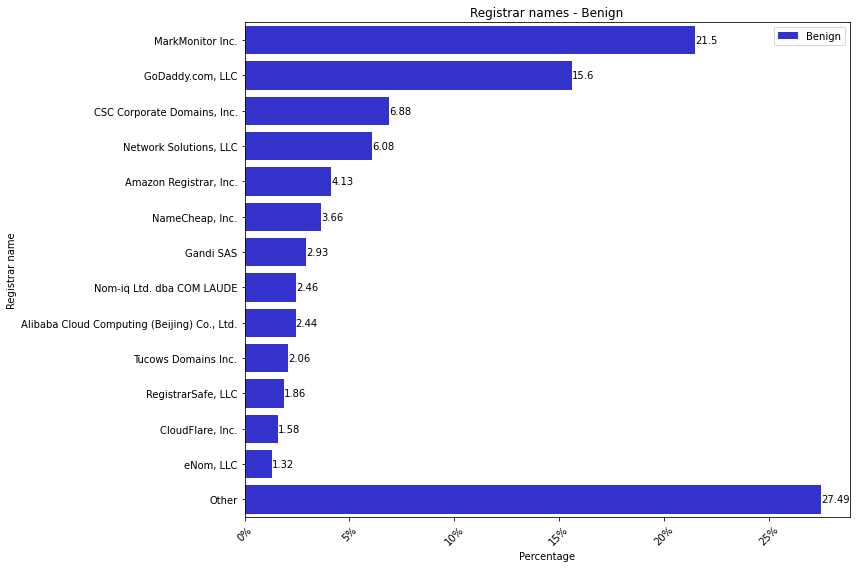

/tmp/ipykernel_81590/3238148929.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  set_yticklabels(yticks_labels)


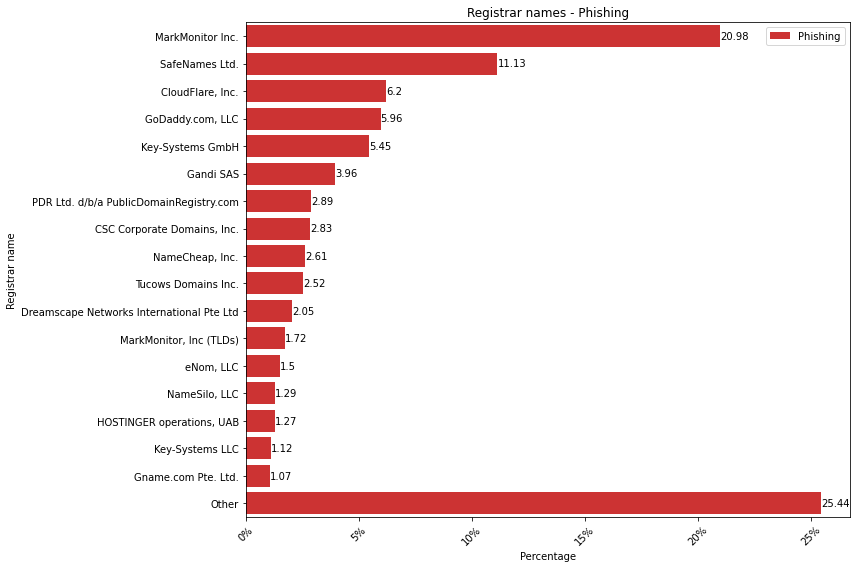

In [154]:
barplot_column_distribution(benign_reg_name_dist, "Registrar name", "Benign", color="b", orient="h")
barplot_column_distribution(misp_reg_name_dist, "Registrar name", "Phishing", color="r", orient="h")

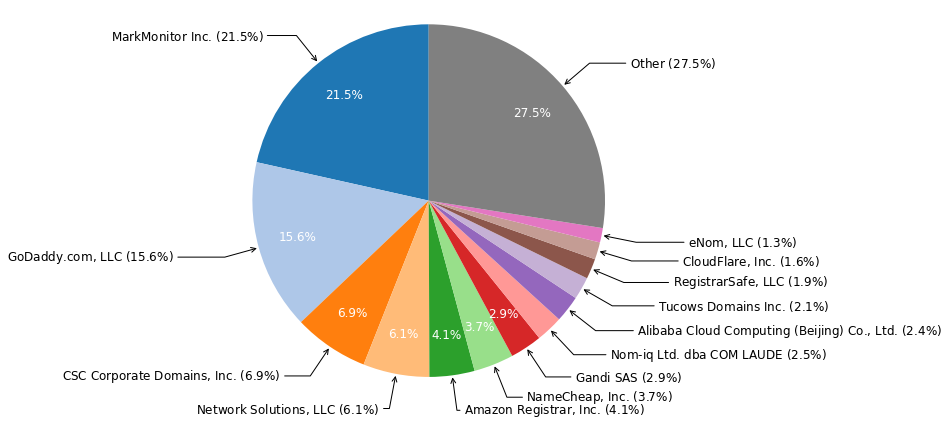

/tmp/ipykernel_81590/4086484152.py:174: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


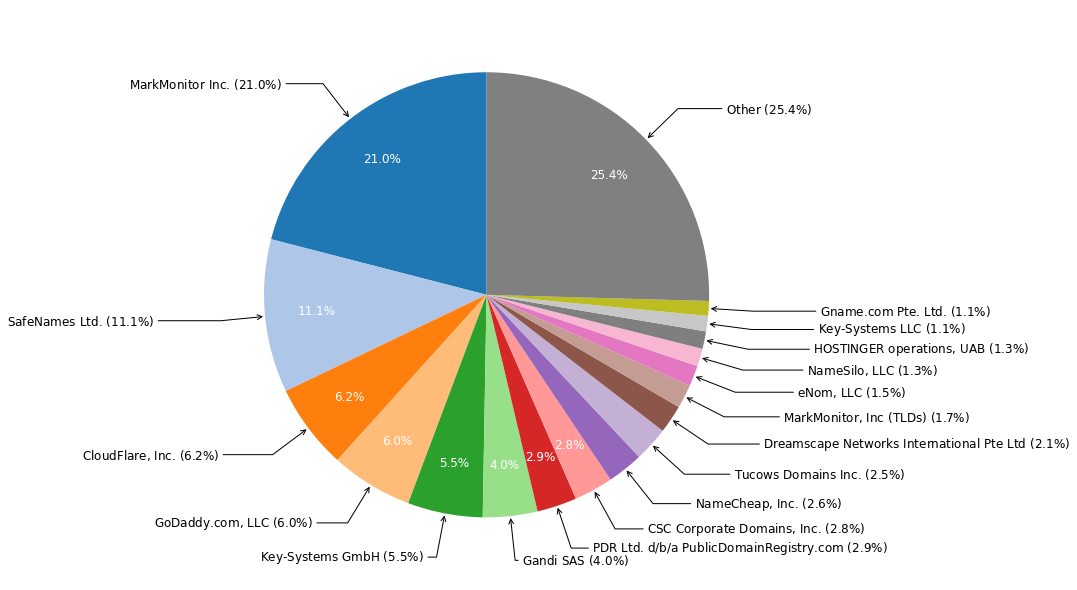

In [158]:
piechart_column_distribution4(benign_reg_name_dist, "Registrar name", "Benign", width=12)
piechart_column_distribution4(misp_reg_name_dist, "Registrar name", "Phishing", height=10)

### Entities

In [12]:
def count_non_empty_objects(entity_list):
    count = sum(1 for obj in entity_list if obj)
    return count

entity_counts = {
    'Entity': ["administrative", "registrant", "registrar", "abuse", "admin", "technical"],
    'Benign': [],
    'Phishing': []
}

# Compute entity counts for df1
for df, df_name in [(benign_rdap, "Benign"), (misp_rdap, "Phishing")]:
    # Filter out rows where "rdap" is None
    df = df[df["rdap"].notna()]

    df["Entities"] = benign_rdap["rdap"].dropna().apply(lambda x: x.get("entities"))

    df_entity_counts = {key: 0 for key in entity_counts["Entity"]}

    def add_counts(entities):
        if type(entities) == dict:
            for key, value in entities.items():
                if key in entity_counts["Entity"]:
                    df_entity_counts[key] += len([x for x in value if x.get("name") or x.get("email")])
    
    df["Entities"].apply(add_counts)
    
    counts = np.array(list(df_entity_counts.values()))
    normalized = counts / counts.sum()
    entity_counts[df_name] = [round(x * 100, 2) for x in normalized]


df_melted = pd.DataFrame(entity_counts).melt('Entity', var_name='Dataset', value_name='Value')
    
# Plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Entity', y='Value', hue='Dataset', data=df_melted, palette={'Benign': 'blue', 'Phishing': 'red'}, saturation=0.5)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.title("Rdap Entity Types")
plt.xticks(rotation=45)

plt.ylabel('Percentage')
yticks_labels = [label.get_text() + " %" for label in ax.get_yticklabels()]
ax.set_yticklabels(yticks_labels)

plt.savefig(f"{image_path}/Rdap_Entity_Types_barplot.png")
plt.savefig(f"{image_path}/Rdap_Entity_Types_barplot.pdf", format="pdf")
plt.show()


NameError: name 'benign_rdap' is not defined

### Domain age

In [25]:
benign_rdap["domain_age"] = benign_rdap["evaluated_on"] - benign_rdap["rdap"].dropna().apply(lambda x: x.get("registration_date"))

misp_rdap["domain_age"] = misp_rdap["evaluated_on"] - misp_rdap["rdap"].dropna().apply(lambda x: x.get("registration_date"))


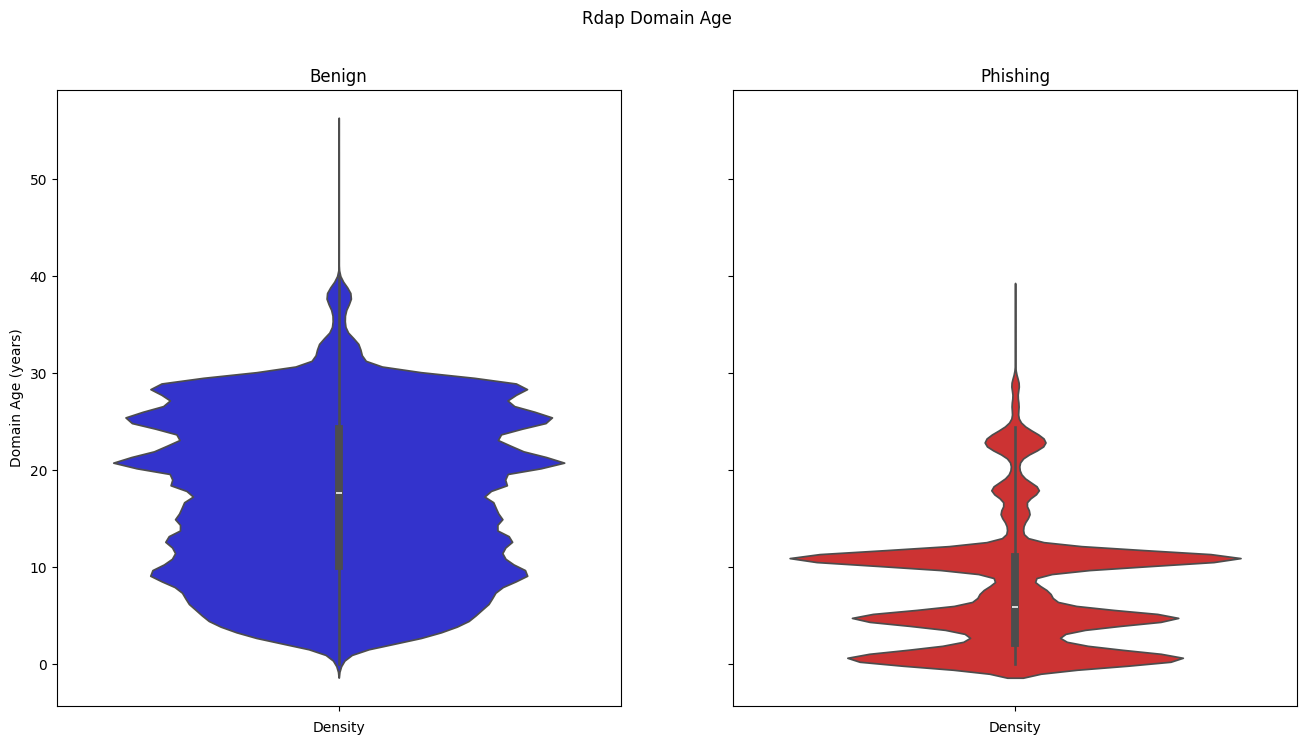

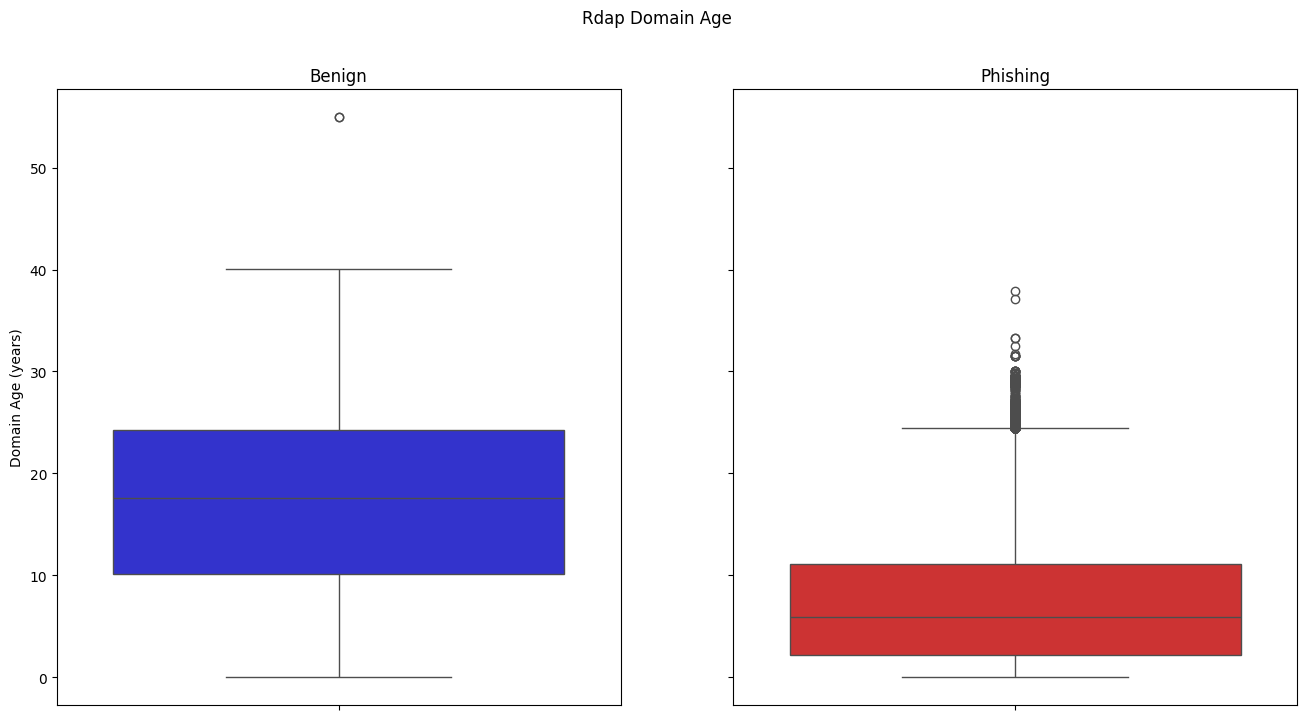

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df1 and df2 are your DataFrames
# Convert timedelta64[ns] to days
benign_rdap['domain_age_years'] = benign_rdap['domain_age'].dt.days / 356
misp_rdap['domain_age_years'] = misp_rdap['domain_age'].dt.days / 356

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Plot the first violin plot (horizontal)
sns.violinplot(y='domain_age_years', data=benign_rdap, color='blue', ax=axes[0], saturation=0.6)
axes[0].set_title('Benign')
axes[0].set_ylabel('Domain Age (years)')
axes[0].set_xlabel('Density')

# Plot the second violin plot (horizontal)
sns.violinplot(y='domain_age_years', data=misp_rdap, color='red', ax=axes[1], saturation=0.6)
axes[1].set_title('Phishing')
axes[1].set_ylabel('Domain Age (years)')
axes[1].set_xlabel('Density')

plt.suptitle('Rdap Domain Age', fontsize=12)

plt.savefig(f"{image_path}/Rdap_Domain_Age_violinplot.png")
plt.savefig(f"{image_path}/Rdap_Domain_Age_violinplot.pdf", format="pdf")
plt.show()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Plot the first violin plot (horizontal)
sns.boxplot(y='domain_age_years', data=benign_rdap, color='blue', ax=axes[0], saturation=0.6)
axes[0].set_title('Benign')
axes[0].set_ylabel('Domain Age (years)')

# Plot the second violin plot (horizontal)
sns.boxplot(y='domain_age_years', data=misp_rdap, color='red', ax=axes[1], saturation=0.6)
axes[1].set_title('Phishing')
axes[1].set_ylabel('Domain Age (years)')

plt.suptitle('Rdap Domain Age', fontsize=12)

plt.savefig(f"{image_path}/Rdap_Domain_Age_boxplot.png")
plt.savefig(f"{image_path}/Rdap_Domain_Age_boxplot.pdf", format="pdf")
plt.show()


## DNS 

### Fetch data

In [4]:
set_image_subpath("dns")

fields_to_fetch = [
    "dns",
]
filed_dict = {key:1 for key in fields_to_fetch}
benign_dns = pd.DataFrame(list(benign.find({}, filed_dict).limit(50_000)))
misp_dns = pd.DataFrame(list(misp.find({}, filed_dict)))

### dns_ttl_*

#### Compute values

In [5]:
from transformers.dns import make_ttl_features

benign_dns["ttls"] = benign_dns["dns"].dropna().apply(lambda x: x.get("ttls")).replace([{}], [None])
benign_ttls = pd.DataFrame(benign_dns.dropna(subset=['ttls']))

benign_ttls["dns_ttl_avg"], benign_ttls["dns_ttl_stdev"], benign_ttls["dns_ttl_low"], benign_ttls["dns_ttl_mid"], benign_ttls["dns_ttl_distinct_count"] = zip(
        *benign_ttls["ttls"].apply(make_ttl_features))


misp_dns["ttls"] = misp_dns["dns"].dropna().apply(lambda x: x.get("ttls"))
misp_ttls = pd.DataFrame(misp_dns.dropna(subset=['ttls']))

misp_ttls["dns_ttl_avg"], misp_ttls["dns_ttl_stdev"], misp_ttls["dns_ttl_low"], misp_ttls["dns_ttl_mid"], misp_ttls["dns_ttl_distinct_count"] = zip(
        *misp_ttls["ttls"].apply(make_ttl_features))



#### Plot the results (split)

/home/ondryaso/miniconda3/envs/pp-research-tools/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ondryaso/miniconda3/envs/pp-research-tools/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ondryaso/miniconda3/envs/pp-research-tools/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ondryaso/miniconda3/envs/pp-research-tools/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

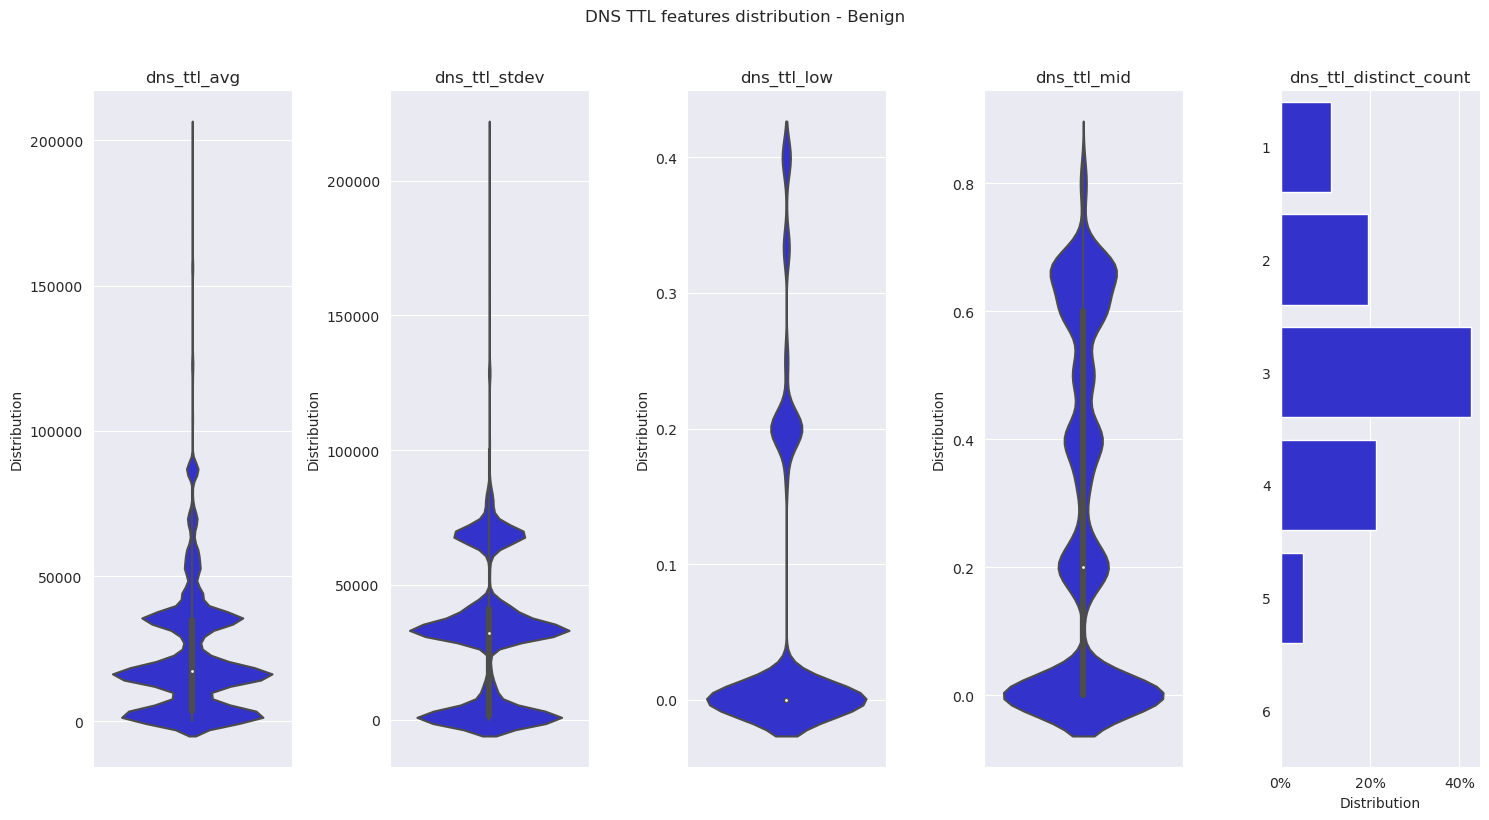

/home/ondryaso/miniconda3/envs/pp-research-tools/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ondryaso/miniconda3/envs/pp-research-tools/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ondryaso/miniconda3/envs/pp-research-tools/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ondryaso/miniconda3/envs/pp-research-tools/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

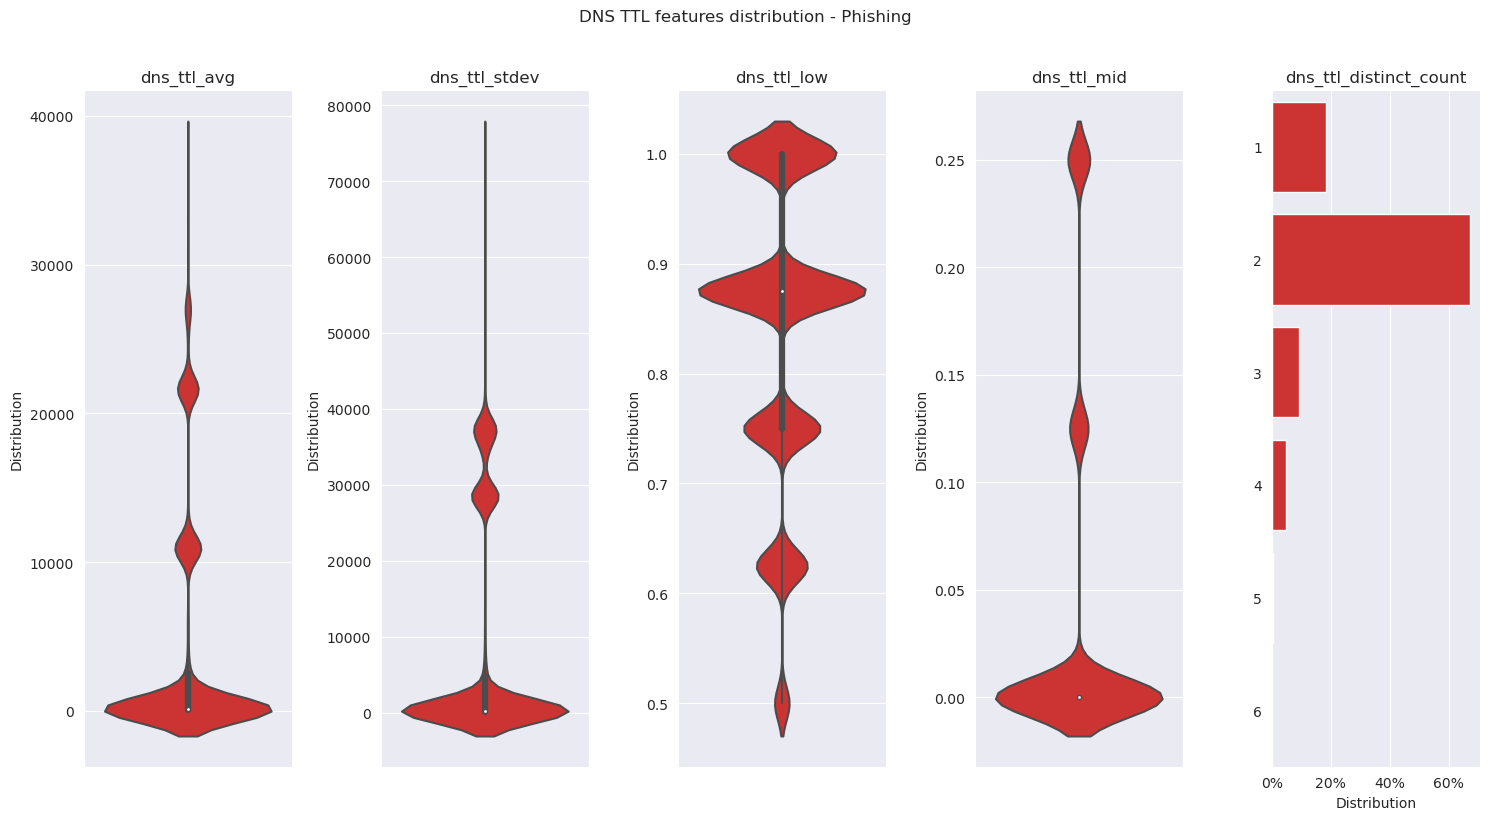

In [7]:
from scipy.stats import zscore

# Specify the features you want to plot
features_to_plot = [("dns_ttl_avg", 0), ("dns_ttl_stdev", 0), ("dns_ttl_low", 0), ("dns_ttl_mid", 0), ("dns_ttl_distinct_count", 1)]

def plot_ttls(df, color, df_name):
    fig, axes = plt.subplots(nrows=1, ncols=len(features_to_plot), figsize=(15, 8))
    # Loop through each feature and create a violin plot
    for i, [feature, discrete] in enumerate(features_to_plot):
        if discrete:
            data = pd.DataFrame(data=df[feature].value_counts(normalize=True).apply(lambda x: round(x * 100, 2)))
            data = data.reset_index()
            ax = sns.barplot(y=feature, x="proportion", ax=axes[i], data=data, color=color, saturation=0.6, orient="h")
            ax.set_ylabel("")
            ax.set_xlabel("Distribution")
            xticks_labels = [f"{x.get_text()}%" for x in ax.get_xticklabels()]
            ax.set_xticklabels(xticks_labels)
        else:
            data = df[feature]
            data = data[(np.abs(zscore(data)) < 2)]
            sns.violinplot(y=data, ax=axes[i], color=color, saturation=0.6)
            axes[i].set_ylabel("Distribution")
            
        axes[i].set_title(feature)
    
    title = f"DNS TTL features distribution - {df_name}"
    # Add a title to the entire plot
    plt.suptitle(title, y=1.02)
    
    # Adjust layout
    plt.tight_layout() 
    # Save
    plt.savefig(f"{image_path}/{title}.png")
    plt.savefig(f"{image_path}/{title}.pdf", format="pdf")
    # Show the plot
    plt.show()

plot_ttls(benign_ttls, "b", "Benign")
plot_ttls(misp_ttls, "r", "Phishing")

#### Plot the results (combined)

/home/ondryaso/miniconda3/envs/pp-research-tools/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ondryaso/miniconda3/envs/pp-research-tools/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ondryaso/miniconda3/envs/pp-research-tools/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ondryaso/miniconda3/envs/pp-research-tools/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

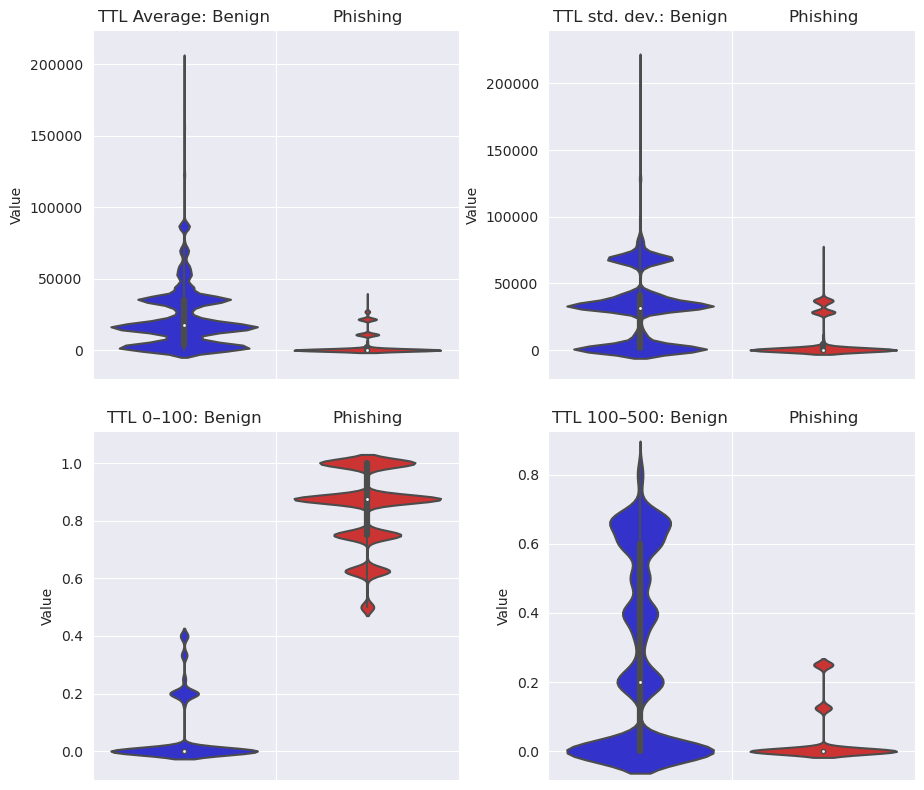

In [24]:
# Specify the features you want to plot
features_to_plot = [("dns_ttl_avg", "TTL Average"), ("dns_ttl_stdev", "TTL std. dev."), ("dns_ttl_low", "TTL 0–100"), ("dns_ttl_mid", "TTL 100–500")]

# Determine the number of rows needed for the subplots
num_rows = int(np.ceil(len(features_to_plot) / 2))

# Create a figure with the required number of subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(10, num_rows * 4))

def plot_ttls(df, color, df_name):
    for i, (feature, title) in enumerate(features_to_plot):
        row = i // 2
        col = (i % 2) * 2 + (0 if df_name == "Benign" else 1)
        
        data = df[feature]
        data = data[(np.abs(zscore(data)) < 2)]
        
        sns.violinplot(y=data, ax=axes[row, col], color=color, saturation=0.6)
        axes[row, col].set_ylabel(None if col % 2 == 1 else "Value")
        plot_title = "Phishing" if df_name == "Phishing" else f"{title}: Benign"
        axes[row, col].set_title(plot_title)

# Plot the features for each dataset
plot_ttls(benign_ttls, "b", "Benign")
plot_ttls(misp_ttls, "r", "Phishing")

# Manually set Y-axis limits for each pair of plots
for i in range(len(features_to_plot)):
    row = i // 2
    col = (i % 2) * 2
    feature = features_to_plot[i][0]

    # Combine the data for both datasets for the current feature
    combined_data = np.concatenate([
        benign_ttls[feature][(np.abs(zscore(benign_ttls[feature])) < 2)],
        misp_ttls[feature][(np.abs(zscore(misp_ttls[feature])) < 2)]
    ])

    # Set the same Y-axis limits for the pair of plots
    min_limit, max_limit = np.min(combined_data), np.max(combined_data)
    min_limit = min_limit - 0.1 * (max_limit - min_limit)
    max_limit = max_limit + 0.1 * (max_limit - min_limit)
    axes[row, col].set_ylim(min_limit, max_limit)
    axes[row, col + 1].set_ylim(min_limit, max_limit)
    
    axes[row, col + 1].set_yticklabels([])
    #axes[row, col + 1].set_yticks([])

# Adjust layout and show the plot
plt.tight_layout()
plt.subplots_adjust(wspace=0.12, hspace=0.15)
# Adjust the spacing between the subplots
for i in range(len(features_to_plot)):
    row = i // 2
    col = (i % 2) * 2

    # Adjust the position of the benign dataset plot
    pos1 = axes[row, col].get_position() # get the original position
    pos1_new = [pos1.x0, pos1.y0, pos1.width * 0.9, pos1.height] 
    axes[row, col].set_position(pos1_new) # set a new position

    # Adjust the position of the phishing dataset plot
    pos2 = axes[row, col + 1].get_position() # get the original position
    pos2_new = [pos1.x0 + pos1.width * 0.9, pos2.y0, pos2.width * 0.9, pos2.height]
    axes[row, col + 1].set_position(pos2_new) # set a new position

title = f"DNS TTL features distribution - combined"
plt.savefig(f"{image_path}/{title}.png")
plt.savefig(f"{image_path}/{title}.pdf", format="pdf")
plt.show()

/home/ondryaso/miniconda3/envs/pp-research-tools/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ondryaso/miniconda3/envs/pp-research-tools/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ondryaso/miniconda3/envs/pp-research-tools/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ondryaso/miniconda3/envs/pp-research-tools/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

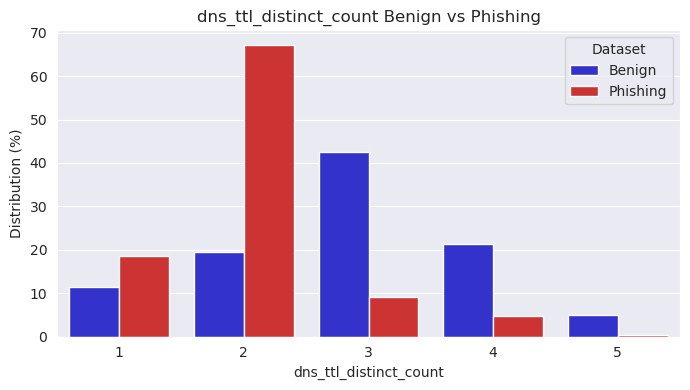

In [20]:
def plot_ttls(benign_df, misp_df, feature):
    # Prepare the data
    benign_data = pd.DataFrame(data=benign_df[feature].value_counts(normalize=True).apply(lambda x: round(x * 100, 2)))
    benign_data = benign_data.reset_index()
    benign_data["Dataset"] = "Benign"

    misp_data = pd.DataFrame(data=misp_df[feature].value_counts(normalize=True).apply(lambda x: round(x * 100, 2)))
    misp_data = misp_data.reset_index()
    misp_data["Dataset"] = "Phishing"

    misp_data.drop(misp_data.tail(1).index,inplace=True) # drop last n rows
    benign_data.drop(benign_data.tail(1).index,inplace=True) # drop last n rows

    # Combine both datasets
    combined_data = pd.concat([benign_data, misp_data])

    # Create the plot
    fig, ax = plt.subplots(figsize=(7, 4))
    sns.barplot(x=feature, y="proportion", hue="Dataset", data=combined_data, ax=ax, saturation=0.6, palette=["b","r"])

    ax.set_ylabel("Distribution (%)")
    ax.set_xlabel(feature)

    # Adjust the layout
    plt.title(f"{feature} Benign vs Phishing")
    plt.tight_layout()


    title = "DNS TTL features distribution - dns_ttl_distinct_count"
    # Save
    plt.savefig(f"{image_path}/{title}.png")
    plt.savefig(f"{image_path}/{title}.pdf", format="pdf")

    # Show the plot
    plt.show()

# Call the function with your dataframes and the feature
plot_ttls(benign_ttls, misp_ttls, "dns_ttl_distinct_count")

### Zone entropy & lenght

#### Calculate values 

In [32]:
from transformers._helpers import get_normalized_entropy

benign_dns["remarks"] = benign_dns["dns"].dropna().apply(lambda x: x.get("remarks"))
benign_dns["zone"] = benign_dns["remarks"].dropna().apply(lambda x: x.get("zone"))
benign_zent = benign_dns.dropna(subset=['zone'])
benign_zent = benign_zent.copy()
benign_zent["zone_entropy"] = benign_zent["zone"].apply(lambda dn: get_normalized_entropy(dn))
benign_zent["zone_len"] = benign_zent["zone"].str.len()

misp_dns["remarks"] = misp_dns["dns"].dropna().apply(lambda x: x.get("remarks"))
misp_dns["zone"] = misp_dns["remarks"].dropna().apply(lambda x: x.get("zone"))
misp_zent = misp_dns.dropna(subset=['zone'])
misp_zent = misp_zent.copy()
misp_zent["zone_entropy"] = misp_zent["zone"].apply(lambda dn: get_normalized_entropy(dn))
misp_zent["zone_len"] = misp_zent["zone"].str.len()

#### plot the results

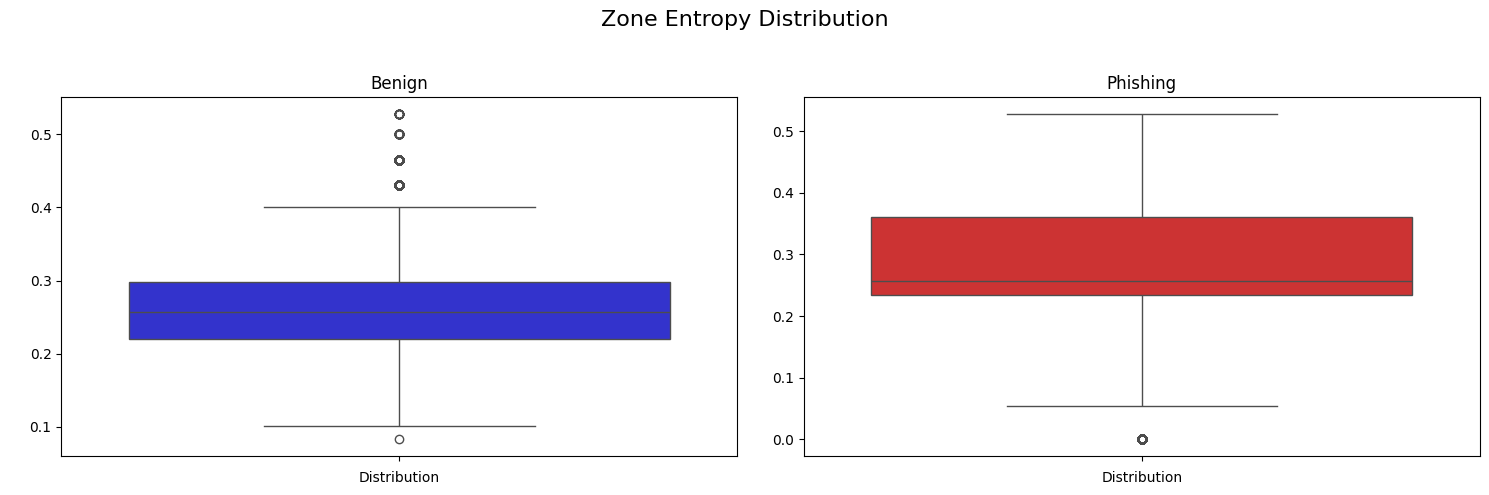

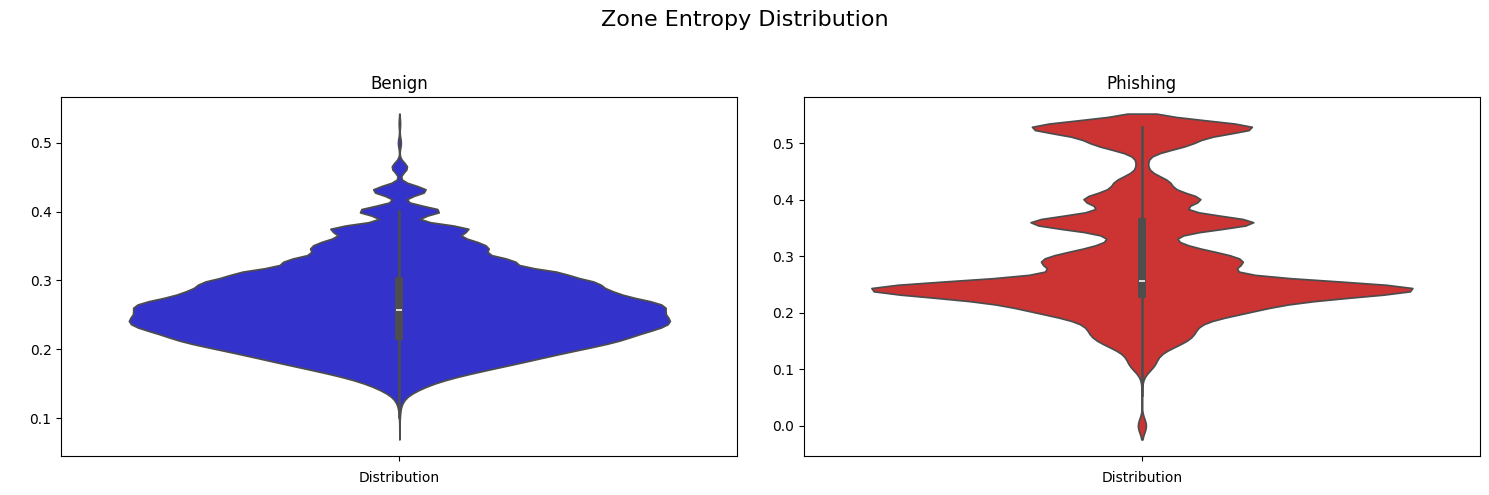

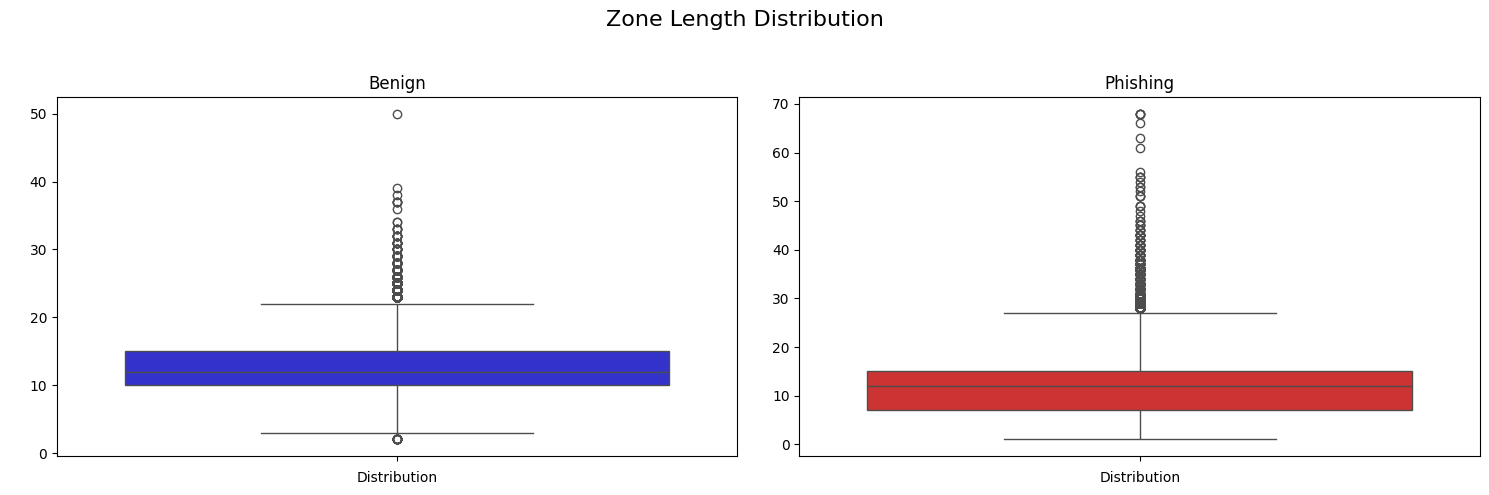

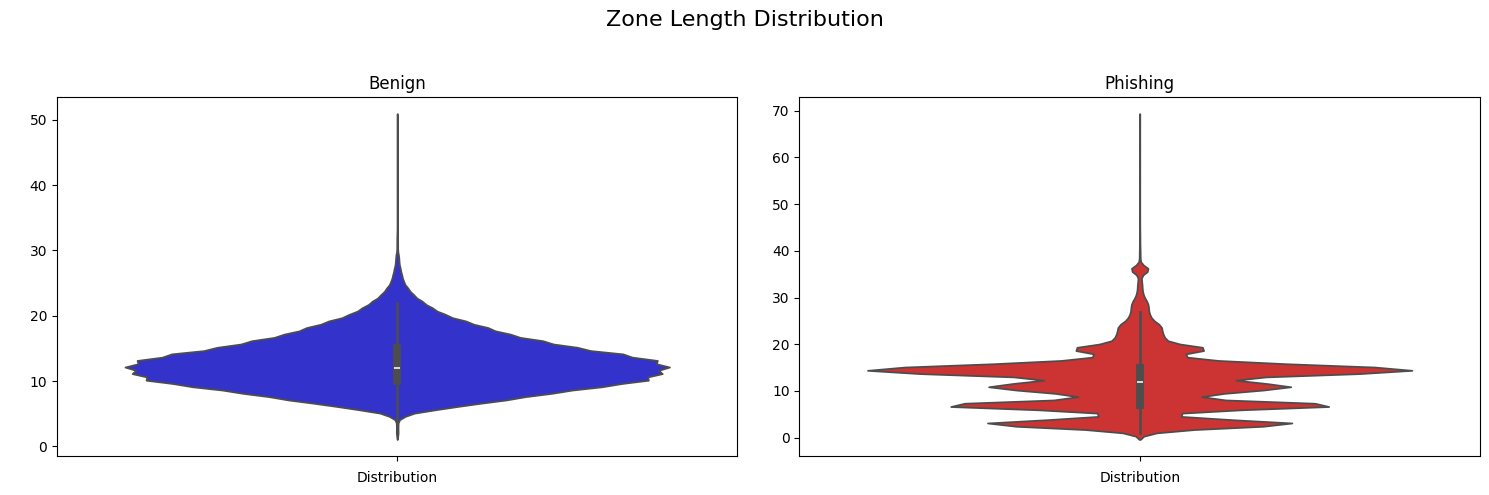

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

for feature, feature_name in [("zone_entropy", "Zone Entropy"), ("zone_len", "Zone Length")]:
    for func, func_name in [(sns.boxplot, "boxplot"), (sns.violinplot, "violinplot")]:
        # Create subplots
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        
        # Plot the violin plots
        func(y=benign_zent[feature], ax=axes[0], color="b", saturation=0.6)
        func(y=misp_zent[feature], ax=axes[1], color="r", saturation=0.6)
        
        # Set labels and title
        axes[0].set_title('Benign')
        axes[1].set_title('Phishing')
        
        title = f"{feature_name} Distribution"
        fig.suptitle(title, fontsize=16)
        
        axes[0].set_xlabel('Distribution')
        axes[1].set_xlabel('Distribution')
        
        axes[0].set_ylabel(' ')
        axes[1].set_ylabel(' ')
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        
        plt.savefig(f"{image_path}/{title}_{func_name}.png")
        plt.savefig(f"{image_path}/{title}_{func_name}.pdf", format="pdf")
        # Show the plot
        plt.show()


### Zone leght

### GEO location

In [11]:
def compute_country_entropy(df):
    # Extract relevant columns
    id_country_data = df[["_id", "geo.country"]]

    # Drop rows with missing country data
    id_country_data = id_country_data.dropna(subset=["ip_data.geo.country"])

    # Group by ID and aggregate country data into lists
    id_country_groups = id_country_data.groupby("_id")["ip_data.geo.country"].agg(list)

    # Calculate country entropy for each ID
    entropy_values = id_country_groups.apply(lambda countries: entropy(np.unique(countries, return_counts=True)[1]))

    # Create a DataFrame with ID and corresponding entropy values
    entropy_df = pd.DataFrame({"_id": entropy_values.index, "country_entropy": entropy_values.values})

    return entropy_df



#### Countries

In [23]:
"""
original code: too slow

import pandas as pd
set_image_subpath("geo")

# feetching benign_ips separately, not to mess up IP distribution analysis
#benign_ips_for_geo = pd.DataFrame(list(benign.find({}, {"ip_data": 1}).limit(2_000)))
#misp_ips_for_geo = pd.DataFrame(list(misp.find({}, {"ip_data": 1}).limit(2_000)))
benign_ips_for_geo = pd.DataFrame(list(benign.find({}, {"ip_data": 1})))
misp_ips_for_geo = pd.DataFrame(list(misp.find({}, {"ip_data": 1})))

benign_coutries_lists, benign_coutries = benign_ips_for_geo["ip_data"].dropna().apply(lambda x: [ip.get("geo").get("country") for ip in x if ip.get("geo")]), []
for l in benign_coutries_lists:
    benign_coutries = benign_coutries + l
benign_coutries = pd.DataFrame(data={"country": benign_coutries})

misp_coutries_lists, misp_coutries = misp_ips_for_geo["ip_data"].dropna().apply(lambda x: [ip.get("geo").get("country") for ip in x if ip.get("geo")]), []
for l in misp_coutries_lists:
    misp_coutries = misp_coutries + l
misp_coutries = pd.DataFrame(data={"country": misp_coutries})
"""


'\noriginal code: too slow\n\nimport pandas as pd\nset_image_subpath("geo")\n\n# feetching benign_ips separately, not to mess up IP distribution analysis\n#benign_ips_for_geo = pd.DataFrame(list(benign.find({}, {"ip_data": 1}).limit(2_000)))\n#misp_ips_for_geo = pd.DataFrame(list(misp.find({}, {"ip_data": 1}).limit(2_000)))\nbenign_ips_for_geo = pd.DataFrame(list(benign.find({}, {"ip_data": 1})))\nmisp_ips_for_geo = pd.DataFrame(list(misp.find({}, {"ip_data": 1})))\n\nbenign_coutries_lists, benign_coutries = benign_ips_for_geo["ip_data"].dropna().apply(lambda x: [ip.get("geo").get("country") for ip in x if ip.get("geo")]), []\nfor l in benign_coutries_lists:\n    benign_coutries = benign_coutries + l\nbenign_coutries = pd.DataFrame(data={"country": benign_coutries})\n\nmisp_coutries_lists, misp_coutries = misp_ips_for_geo["ip_data"].dropna().apply(lambda x: [ip.get("geo").get("country") for ip in x if ip.get("geo")]), []\nfor l in misp_coutries_lists:\n    misp_coutries = misp_coutries

In [24]:
set_image_subpath("geo")

import pandas as pd
from pymongo import MongoClient


# Function to process and flatten geo data
def process_geo_data(data):
    geo_data = []
    for record in data:
        ip_data_list = record.get('ip_data', [])
        for ip_data in ip_data_list:
            geo = ip_data.get('geo')
            if geo:
                geo_data.append(geo)
    return pd.DataFrame(geo_data)

# Fetch only the geo data from MongoDB
benign_geo_data = list(benign.find({}, {"ip_data.geo": 1}))
misp_geo_data = list(misp.find({}, {"ip_data.geo": 1}))

# Extract and process geo data
benign_geo_df = process_geo_data(benign_geo_data)
misp_geo_df = process_geo_data(misp_geo_data)

benign_geo_df
misp_geo_df

benign_geo_df.head()

,country,country_code,region,region_code,city,postal_code,latitude,longitude,timezone,isp,org,asn,as_org
0,United States,US,Maryland,MD,Marriottsville,21104,39.3385,-76.9201,America/New_York,None,None,NaN,NaN
1,Netherlands,NL,Groningen,GR,Groningen,9711,53.2157,6.5765,Europe/Amsterdam,None,None,NaN,NaN
2,United States,US,California,CA,None,None,34.0544,-118.2440,America/Los_Angeles,None,None,NaN,NaN
3,United States,US,None,None,None,None,37.7510,-97.8220,America/Chicago,None,None,NaN,NaN
4,United States,US,None,None,None,None,37.7510,-97.8220,America/Chicago,None,None,NaN,NaN


In [25]:
set_image_subpath("geo")

# Replace "United States" with "USA" in both DataFrames
benign_geo_df["country"] = benign_geo_df["country"].replace("United States", "USA")
misp_geo_df["country"] = misp_geo_df["country"].replace("United States", "USA")

benign_coutries = benign_geo_df["country"]
misp_coutries = misp_geo_df["country"]

benign_top_n = 0.010
misp_top_n = 0.010

benign_coutry_dist = calculate_column_distribution(benign_geo_df, "country", benign_top_n)
misp_coutry_dist = calculate_column_distribution(misp_geo_df, "country", misp_top_n)

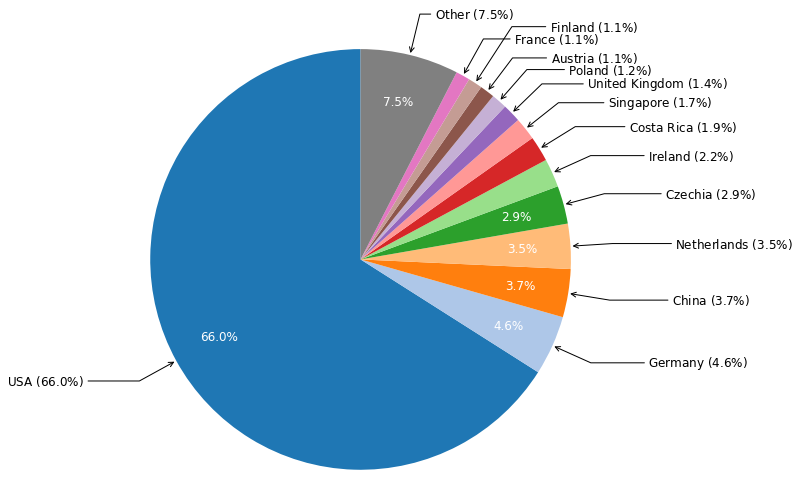

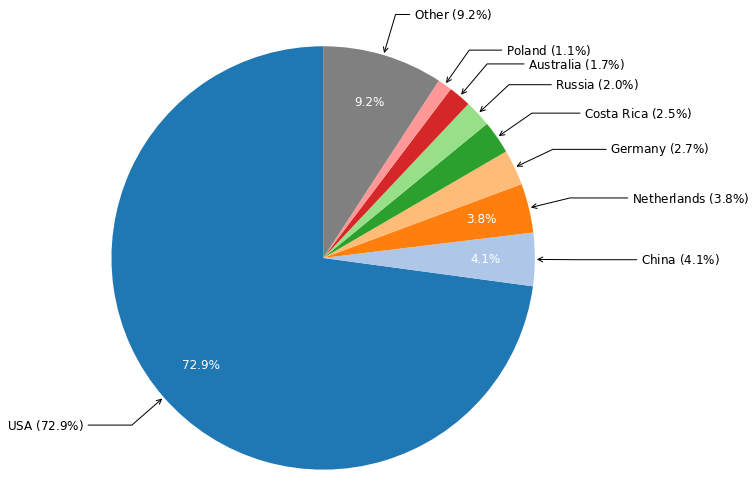

In [26]:
feature_name = "Countrie"
# Plot the Benign data
# barplot_column_distribution(benign_coutry_dist, feature_name, "Benign", color="b", log_scale=True, bottom=1e-0)
piechart_column_distribution5(benign_coutry_dist, feature_name, "Benign", width=9, height=7)
# Plot the Phishing data
# barplot_column_distribution(misp_coutry_dist, feature_name, "Phishing", color="r", log_scale=True, bottom=1e-0)
piechart_column_distribution5(misp_coutry_dist, feature_name, "Phishing", width=9, height=7)

In [28]:
#print(w_benign_ips["geo.country"].value_counts()[:10])

### Countries v2 - only one (top) country per domain name

In [29]:
import pandas as pd
from pymongo import MongoClient
from collections import Counter

def process_geo_data(data):
    geo_data = []
    for record in data:
        ip_data_list = record.get('ip_data', [])
        # Ensure ip_data and ip_data['geo'] are not None before accessing 'country'
        countries = [ip_data['geo']['country'] for ip_data in ip_data_list if ip_data and ip_data.get('geo') and 'country' in ip_data['geo']]
        if countries:
            most_common_country = Counter(countries).most_common(1)[0][0]
            geo_data.append({'country': most_common_country})
    return pd.DataFrame(geo_data)

# Assuming 'benign' and 'misp' are your MongoDB collections
perdomain_benign_geo_data = list(benign.find({}, {"ip_data.geo": 1}))
perdomain_misp_geo_data = list(misp.find({}, {"ip_data.geo": 1}))

# Extract and process geo data
perdomain_benign_geo_df = process_geo_data(perdomain_benign_geo_data)
perdomain_misp_geo_df = process_geo_data(perdomain_misp_geo_data)

# Rest of your code for calculating distributions and plotting


In [30]:
benign_coutries = benign_geo_df["country"]
misp_coutries = misp_geo_df["country"]

benign_top_n = 0.013
misp_top_n = 0.010

benign_coutry_dist = calculate_column_distribution(perdomain_benign_geo_df, "country", benign_top_n)
misp_coutry_dist = calculate_column_distribution(perdomain_misp_geo_df, "country", misp_top_n)

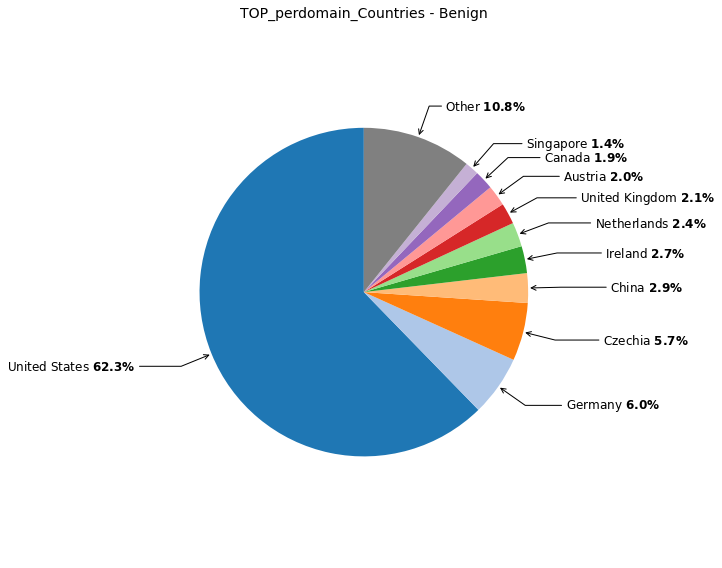

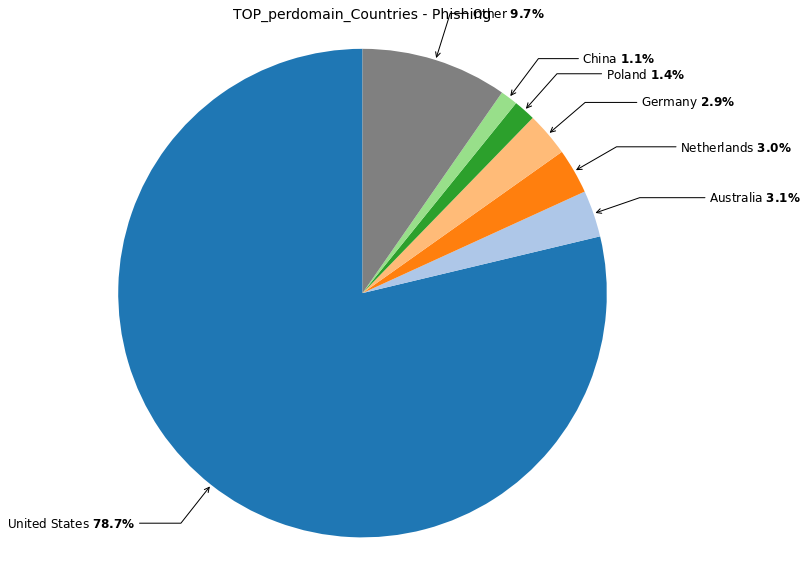

In [31]:
feature_name = "TOP_perdomain_Countrie"
# Plot the Benign data
# barplot_column_distribution(benign_coutry_dist, feature_name, "Benign", color="b", log_scale=True, bottom=1e-0)
piechart_column_distribution3(benign_coutry_dist, feature_name, "Benign")
# Plot the Phishing data
# barplot_column_distribution(misp_coutry_dist, feature_name, "Phishing", color="r", log_scale=True, bottom=1e-0)
piechart_column_distribution3(misp_coutry_dist, feature_name, "Phishing")

#### Countries the on World map

In [ ]:
"""
original version

import geopandas as gpd
import matplotlib.pyplot as plt


# Extract latitude and longitude from the 'geo' field
w_benign_ips['Latitude'] = w_benign_ips["ip_data"].apply(lambda x: x.get('geo').get('latitude') if x.get('geo') else None)
w_benign_ips['Longitude'] = w_benign_ips["ip_data"].apply(lambda x: x.get('geo').get('longitude') if x.get('geo') else None)
w_benign_ips = w_benign_ips.dropna(subset=["Latitude"])
w_benign_ips = w_benign_ips.dropna(subset=["Longitude"])

w_misp_ips['Latitude'] = w_misp_ips["ip_data"].apply(lambda x: x.get('geo').get('latitude') if x.get('geo') else None)
w_misp_ips['Longitude'] = w_misp_ips["ip_data"].apply(lambda x: x.get('geo').get('longitude') if x.get('geo') else None)
w_misp_ips = w_misp_ips.dropna(subset=["Latitude"])
w_misp_ips = w_misp_ips.dropna(subset=["Longitude"])

# Create a GeoDataFrame
gdf_benign = gpd.GeoDataFrame(w_benign_ips, geometry=gpd.points_from_xy(w_benign_ips['Longitude'], w_benign_ips['Latitude']))
gdf_misp = gpd.GeoDataFrame(w_misp_ips, geometry=gpd.points_from_xy(w_misp_ips['Longitude'], w_misp_ips['Latitude']))

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the world map
ax = world.plot(figsize=(15, 6), edgecolor='black', color='lightgray')

# Plot the scatter points on top of the world map
gdf_benign.plot(ax=ax, color='blue', marker='o', markersize=10, label='Benign')
gdf_misp.plot(ax=ax, color='red', marker='o', markersize=10, label='MISP')

# Set axis labels and title
ax.set_axis_off()
plt.title('IP Locations on the World Map')

# Add a legend
plt.legend()

# Show the plot
plt.savefig(f"{image_path}/IPs_scattered_on_map.png")
plt.show()
"""

/tmp/ipykernel_105838/1039592788.py:16: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


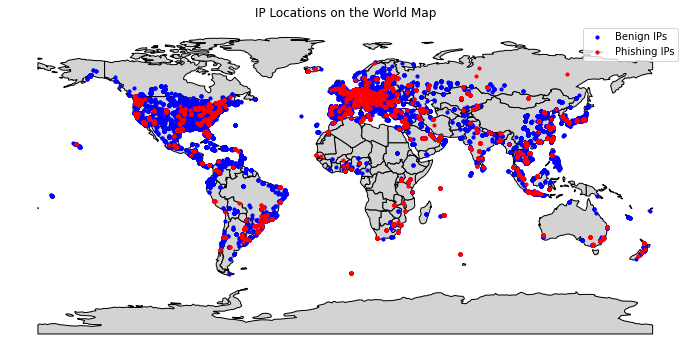

In [32]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming benign_geo_df and misp_geo_df are the DataFrames you obtained from the process_geo_data function
# and they already contain 'latitude' and 'longitude' columns

# Drop rows where latitude or longitude is None (or NaN)
benign_geo_df = benign_geo_df.dropna(subset=["latitude", "longitude"])
misp_geo_df = misp_geo_df.dropna(subset=["latitude", "longitude"])

# Create GeoDataFrames
gdf_benign = gpd.GeoDataFrame(benign_geo_df, geometry=gpd.points_from_xy(benign_geo_df['longitude'], benign_geo_df['latitude']))
gdf_misp = gpd.GeoDataFrame(misp_geo_df, geometry=gpd.points_from_xy(misp_geo_df['longitude'], misp_geo_df['latitude']))

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the world map
ax = world.plot(figsize=(15, 6), edgecolor='black', color='lightgray')

# Plot the scatter points on top of the world map
gdf_benign.plot(ax=ax, color='blue', marker='o', markersize=10, label='Benign IPs')
gdf_misp.plot(ax=ax, color='red', marker='o', markersize=10, label='Phishing IPs')

# Set axis labels and title
ax.set_axis_off()
plt.title('IP Locations on the World Map')

# Add a legend
plt.legend()

# Show the plot
plt.savefig(f"{image_path}/IPs_scattered_on_map.png")
plt.show()


/tmp/ipykernel_105838/775047989.py:38: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


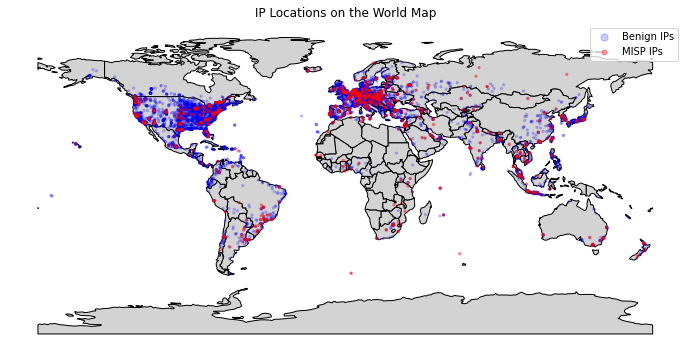

In [33]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Function to normalize counts and scale to specified range
def scale_counts(counts, min_size, max_size):
    scaler = MinMaxScaler(feature_range=(min_size, max_size))
    scaled_sizes = scaler.fit_transform(counts.values.reshape(-1, 1))
    return scaled_sizes.flatten()

# Minimum and maximum sizes for the points
benign_min_size = 5  # Specify the minimum size of the points here
benign_max_size = 100  # Specify the maximum size of the points here

malign_min_size = 5
malign_max_size = 40

# Assuming benign_geo_df and misp_geo_df are the DataFrames you obtained from the process_geo_data function
# and they already contain 'latitude' and 'longitude' columns

# Drop rows where latitude or longitude is None (or NaN)
benign_geo_df = benign_geo_df.dropna(subset=["latitude", "longitude"])
misp_geo_df = misp_geo_df.dropna(subset=["latitude", "longitude"])

# Group by latitude and longitude and count the occurrences
benign_counts = benign_geo_df.groupby(['latitude', 'longitude']).size().reset_index(name='counts')
misp_counts = misp_geo_df.groupby(['latitude', 'longitude']).size().reset_index(name='counts')

# Normalize and scale the sizes of the points
benign_counts['scaled_counts'] = scale_counts(benign_counts[['counts']], benign_min_size, benign_max_size)
misp_counts['scaled_counts'] = scale_counts(misp_counts[['counts']], malign_min_size, malign_max_size)

# Create GeoDataFrames
gdf_benign = gpd.GeoDataFrame(benign_counts, geometry=gpd.points_from_xy(benign_counts['longitude'], benign_counts['latitude']))
gdf_misp = gpd.GeoDataFrame(misp_counts, geometry=gpd.points_from_xy(misp_counts['longitude'], misp_counts['latitude']))

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the world map
ax = world.plot(figsize=(15, 6), edgecolor='black', color='lightgray')

# Plot the scatter points on top of the world map with scaled sizes and some transparency
gdf_benign.plot(ax=ax, color='blue', marker='o', markersize=gdf_benign['scaled_counts'], label='Benign IPs', alpha=0.2)
gdf_misp.plot(ax=ax, color='red', marker='o', markersize=gdf_misp['scaled_counts'], label='MISP IPs', alpha=0.4)

# Set axis labels and title
ax.set_axis_off()
plt.title('IP Locations on the World Map')

# Add a legend
plt.legend()

# Show the plot
plt.savefig(f"{image_path}/IPs_scattered_on_map.png")
plt.show()


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Function to normalize counts and scale to specified range
def scale_counts(df, min_size, max_size, regions=None, region_min_size=None, region_max_size=None):
    # Initialize the scaled_counts with the default scaling
    df['scaled_counts'] = MinMaxScaler(feature_range=(min_size, max_size)).fit_transform(df['counts'].values.reshape(-1, 1)).flatten()
    
    # Check if region-specific scaling is required
    if regions and region_min_size and region_max_size:
        for region in regions:
            within_region = (
                (df['latitude'] >= region['lat_min']) & 
                (df['latitude'] <= region['lat_max']) & 
                (df['longitude'] >= region['lon_min']) & 
                (df['longitude'] <= region['lon_max'])
            )
            # Scale sizes for locations within the region differently
            df.loc[within_region, 'scaled_counts'] = MinMaxScaler(feature_range=(region_min_size, region_max_size)).fit_transform(df.loc[within_region, 'counts'].values.reshape(-1, 1)).flatten()

    return df

# Additional dirty hack
# Nothern-american phishing domains were barely visible due to high amount of benign

# Define the latitude and longitude bounds for North and Middle America and China
regions_bounds = [
    {
        'lat_min': 5,     # Middle America
        'lat_max': 70,    # North America
        'lon_min': -170,  # Westernmost point of North America
        'lon_max': -50,   # Easternmost point of Middle America
    },
#    {
#        'lat_min': 18,    # Southernmost point of China
#        'lat_max': 53,    # Northernmost point of China
#        'lon_min': 73,    # Westernmost point of China
#        'lon_max': 135,   # Easternmost point of China
#    }

]

# Minimum and maximum sizes for the points
benign_min_size = 5
benign_max_size = 100

# Malign locations are above
malign_min_size = 3
malign_max_size = 50

# Enhanced sizes for malign points in the specified regions
region_malign_min_size = 7
region_malign_max_size = 100

# Drop rows where latitude or longitude is None (or NaN)
benign_geo_df = benign_geo_df.dropna(subset=["latitude", "longitude"])
misp_geo_df = misp_geo_df.dropna(subset=["latitude", "longitude"])

# Group by latitude and longitude and count the occurrences
benign_counts = benign_geo_df.groupby(['latitude', 'longitude']).size().reset_index(name='counts')
misp_counts = misp_geo_df.groupby(['latitude', 'longitude']).size().reset_index(name='counts')

# Normalize and scale the sizes of the points, with special treatment for malign points in the specified regions
benign_counts = scale_counts(benign_counts, benign_min_size, benign_max_size)
misp_counts = scale_counts(misp_counts, malign_min_size, malign_max_size, regions_bounds, region_malign_min_size, region_malign_max_size)

# Create GeoDataFrames
gdf_benign = gpd.GeoDataFrame(benign_counts, geometry=gpd.points_from_xy(benign_counts['longitude'], benign_counts['latitude']))
gdf_misp = gpd.GeoDataFrame(misp_counts, geometry=gpd.points_from_xy(misp_counts['longitude'], misp_counts['latitude']))

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the world map
ax = world.plot(figsize=(15, 6), edgecolor='black', color='lightgray')

# Plot the scatter points on top of the world map with scaled sizes and some transparency
gdf_benign.plot(ax=ax, color='blue', marker='o', markersize=gdf_benign['scaled_counts'], label='Benign IPs', alpha=0.2)
gdf_misp.plot(ax=ax, color='red', marker='o', markersize=gdf_misp['scaled_counts'], label='MISP IPs', alpha=0.4)

# Set axis labels and title
ax.set_axis_off()
#plt.title('IP Locations on the World Map')

# Add a legend
plt.legend()

# Show the plot
plt.savefig(f"{image_path}/IPs_scattered_on_map.png")
plt.savefig(f"{image_path}/IPs_scattered_on_map.pdf", format="pdf")
plt.show()


/tmp/ipykernel_105838/2944097754.py:73: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [ ]:
# default regions config (if necessary)

regions_config = [
    # North America
    {'type': 'benign', 'bounds': {'lat_min': 30, 'lat_max': 70, 'lon_min': -125, 'lon_max': -70},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': 30, 'lat_max': 70, 'lon_min': -125, 'lon_max': -70},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # Middle America
    {'type': 'benign', 'bounds': {'lat_min': 12, 'lat_max': 30, 'lon_min': -117, 'lon_max': -80},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': 12, 'lat_max': 30, 'lon_min': -117, 'lon_max': -80},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # South America
    {'type': 'benign', 'bounds': {'lat_min': -55, 'lat_max': 12, 'lon_min': -81, 'lon_max': -34},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': -55, 'lat_max': 12, 'lon_min': -81, 'lon_max': -34},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # Western Europe
    {'type': 'benign', 'bounds': {'lat_min': 35, 'lat_max': 55, 'lon_min': -10, 'lon_max': 10},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': 35, 'lat_max': 55, 'lon_min': -10, 'lon_max': 10},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # Middle Europe
    {'type': 'benign', 'bounds': {'lat_min': 44, 'lat_max': 55, 'lon_min': 10, 'lon_max': 30},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': 44, 'lat_max': 55, 'lon_min': 10, 'lon_max': 30},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # Northern Europe
    {'type': 'benign', 'bounds': {'lat_min': 55, 'lat_max': 70, 'lon_min': -10, 'lon_max': 30},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': 55, 'lat_max': 70, 'lon_min': -10, 'lon_max': 30},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # Eastern Europe
    {'type': 'benign', 'bounds': {'lat_min': 44, 'lat_max': 55, 'lon_min': 30, 'lon_max': 60},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': 44, 'lat_max': 55, 'lon_min': 30, 'lon_max': 60},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # Southern Europe
    {'type': 'benign', 'bounds': {'lat_min': 35, 'lat_max': 44, 'lon_min': -10, 'lon_max': 30},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': 35, 'lat_max': 44, 'lon_min': -10, 'lon_max': 30},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # Asia
    # Western Asia (Middle East)
    {'type': 'benign', 'bounds': {'lat_min': 12, 'lat_max': 45, 'lon_min': 34, 'lon_max': 60},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': 12, 'lat_max': 45, 'lon_min': 34, 'lon_max': 60},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # Central Asia
    {'type': 'benign', 'bounds': {'lat_min': 36, 'lat_max': 55, 'lon_min': 60, 'lon_max': 85},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': 36, 'lat_max': 55, 'lon_min': 60, 'lon_max': 85},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # South Asia
    {'type': 'benign', 'bounds': {'lat_min': 5, 'lat_max': 35, 'lon_min': 65, 'lon_max': 90},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': 5, 'lat_max': 35, 'lon_min': 65, 'lon_max': 90},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # East Asia
    {'type': 'benign', 'bounds': {'lat_min': 20, 'lat_max': 50, 'lon_min': 100, 'lon_max': 140},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': 20, 'lat_max': 50, 'lon_min': 100, 'lon_max': 140},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # Southeast Asia
    {'type': 'benign', 'bounds': {'lat_min': -11, 'lat_max': 20, 'lon_min': 95, 'lon_max': 155},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': -11, 'lat_max': 20, 'lon_min': 95, 'lon_max': 155},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # Africa
    # Northern Africa
    {'type': 'benign', 'bounds': {'lat_min': 19, 'lat_max': 37, 'lon_min': -17, 'lon_max': 35},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': 19, 'lat_max': 37, 'lon_min': -17, 'lon_max': 35},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # Western Africa
    {'type': 'benign', 'bounds': {'lat_min': 4, 'lat_max': 19, 'lon_min': -17, 'lon_max': 10},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': 4, 'lat_max': 19, 'lon_min': -17, 'lon_max': 10},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # Eastern Africa
    {'type': 'benign', 'bounds': {'lat_min': -11, 'lat_max': 18, 'lon_min': 33, 'lon_max': 51},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': -11, 'lat_max': 18, 'lon_min': 33, 'lon_max': 51},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # Central Africa
    {'type': 'benign', 'bounds': {'lat_min': -6, 'lat_max': 10, 'lon_min': 10, 'lon_max': 33},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': -6, 'lat_max': 10, 'lon_min': 10, 'lon_max': 33},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # Southern Africa
    {'type': 'benign', 'bounds': {'lat_min': -35, 'lat_max': -6, 'lon_min': 16, 'lon_max': 40},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': -35, 'lat_max': -6, 'lon_min': 16, 'lon_max': 40},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # Australia (Oceania)
    {'type': 'benign', 'bounds': {'lat_min': -50, 'lat_max': -10, 'lon_min': 110, 'lon_max': 155},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': -50, 'lat_max': -10, 'lon_min': 110, 'lon_max': 155},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
]

In [46]:
"""
Computationally complex per-region settings (not used)

import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Function to normalize counts and scale to specified range
def scale_counts(df, regions, default_settings):
    # Apply region-specific scaling
    for region in regions:
        within_region = (
            (df['latitude'] >= region['bounds']['lat_min']) & 
            (df['latitude'] <= region['bounds']['lat_max']) & 
            (df['longitude'] >= region['bounds']['lon_min']) & 
            (df['longitude'] <= region['bounds']['lon_max'])
        )
        df.loc[within_region, region['type'] + '_scaled_counts'] = MinMaxScaler(feature_range=(region['min_size'], region['max_size'])).fit_transform(df.loc[within_region, 'counts'].values.reshape(-1, 1)).flatten()
        df.loc[within_region, region['type'] + '_alpha'] = region['alpha']

    # Identify regions not covered by regions_config
    not_covered = ~(df['benign_scaled_counts'].notna() | df['malign_scaled_counts'].notna())

    # Apply default scaling for non-region specific locations
    df.loc[not_covered, 'benign_scaled_counts'] = MinMaxScaler(feature_range=(default_settings['benign']['min_size'], default_settings['benign']['max_size'])).fit_transform(df.loc[not_covered, 'counts'].values.reshape(-1, 1)).flatten()
    df.loc[not_covered, 'malign_scaled_counts'] = MinMaxScaler(feature_range=(default_settings['malign']['min_size'], default_settings['malign']['max_size'])).fit_transform(df.loc[not_covered, 'counts'].values.reshape(-1, 1)).flatten()
    df['benign_alpha'] = df['benign_alpha'].fillna(default_settings['benign']['alpha'])
    df['malign_alpha'] = df['malign_alpha'].fillna(default_settings['malign']['alpha'])

    return df

# Define default settings for benign and malign points
default_settings = {
    'benign': {'min_size': 5, 'max_size': 100, 'alpha': 0.4},
    'malign': {'min_size': 5, 'max_size': 100, 'alpha': 0.4}
}


regions_config = [
    # North America
    {'type': 'benign', 'bounds': {'lat_min': 30, 'lat_max': 70, 'lon_min': -125, 'lon_max': -70},
     'min_size':  5, 'max_size': 70, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': 30, 'lat_max': 70, 'lon_min': -125, 'lon_max': -70},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # Middle America
    {'type': 'benign', 'bounds': {'lat_min': 12, 'lat_max': 30, 'lon_min': -117, 'lon_max': -80},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': 12, 'lat_max': 30, 'lon_min': -117, 'lon_max': -80},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # Western Europe
    {'type': 'benign', 'bounds': {'lat_min': 35, 'lat_max': 55, 'lon_min': -10, 'lon_max': 10},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': 35, 'lat_max': 55, 'lon_min': -10, 'lon_max': 10},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    # Middle Europe
    {'type': 'benign', 'bounds': {'lat_min': 44, 'lat_max': 55, 'lon_min': 10, 'lon_max': 30},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': 44, 'lat_max': 55, 'lon_min': 10, 'lon_max': 30},
     'min_size': 5, 'max_size': 50, 'alpha': 0.4},
    # East Asia
    {'type': 'benign', 'bounds': {'lat_min': 20, 'lat_max': 50, 'lon_min': 100, 'lon_max': 140},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
    {'type': 'malign', 'bounds': {'lat_min': 20, 'lat_max': 50, 'lon_min': 100, 'lon_max': 140},
     'min_size': 10, 'max_size': 100, 'alpha': 0.4},
]

# Drop rows where latitude or longitude is None (or NaN)
benign_geo_df = benign_geo_df.dropna(subset=["latitude", "longitude"])
misp_geo_df = misp_geo_df.dropna(subset=["latitude", "longitude"])

# Group by latitude and longitude and count the occurrences
benign_counts = benign_geo_df.groupby(['latitude', 'longitude']).size().reset_index(name='counts')
misp_counts = misp_geo_df.groupby(['latitude', 'longitude']).size().reset_index(name='counts')

# Normalize and scale the sizes of the points
benign_counts = scale_counts(benign_counts, regions_config, default_settings)
misp_counts = scale_counts(misp_counts, regions_config, default_settings)

# Create GeoDataFrames
gdf_benign = gpd.GeoDataFrame(benign_counts, geometry=gpd.points_from_xy(benign_counts['longitude'], benign_counts['latitude']))
gdf_malign = gpd.GeoDataFrame(misp_counts, geometry=gpd.points_from_xy(misp_counts['longitude'], misp_counts['latitude']))

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the world map
ax = world.plot(figsize=(15, 6), edgecolor='black', color='lightgray')

# Plot the scatter points on top of the world map with scaled sizes and specified alpha
for _, row in gdf_benign.iterrows():
    ax.scatter(x=row['geometry'].x, y=row['geometry'].y, s=row['benign_scaled_counts'], color='blue', alpha=row['benign_alpha'], label='Benign IPs')
for _, row in gdf_malign.iterrows():
    ax.scatter(x=row['geometry'].x, y=row['geometry'].y, s=row['malign_scaled_counts'], color='red', alpha=row['malign_alpha'], label='MISP IPs')

# Set axis labels and title
ax.set_axis_off()
plt.title('IP Locations on the World Map')

# Add a legend with unique entries
handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique))

# Show the plot
plt.savefig(f"{image_path}/IPs_scattered_on_map.png")
plt.show()
"""

'\nComputationally complex per-region settings (not used)\n\nimport geopandas as gpd\nimport matplotlib.pyplot as plt\nfrom sklearn.preprocessing import MinMaxScaler\n\n# Function to normalize counts and scale to specified range\ndef scale_counts(df, regions, default_settings):\n    # Apply region-specific scaling\n    for region in regions:\n        within_region = (\n            (df[\'latitude\'] >= region[\'bounds\'][\'lat_min\']) & \n            (df[\'latitude\'] <= region[\'bounds\'][\'lat_max\']) & \n            (df[\'longitude\'] >= region[\'bounds\'][\'lon_min\']) & \n            (df[\'longitude\'] <= region[\'bounds\'][\'lon_max\'])\n        )\n        df.loc[within_region, region[\'type\'] + \'_scaled_counts\'] = MinMaxScaler(feature_range=(region[\'min_size\'], region[\'max_size\'])).fit_transform(df.loc[within_region, \'counts\'].values.reshape(-1, 1)).flatten()\n        df.loc[within_region, region[\'type\'] + \'_alpha\'] = region[\'alpha\']\n\n    # Identify regions not c

In [192]:
"""
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `ip_data` is your DataFrame with the IP data schema

# Extract latitude and longitude from the 'geo' field
w_benign_ips['Latitude'] = w_benign_ips["ip_data"].apply(lambda x: x.get('geo').get('latitude') if x.get('geo') else None)
w_benign_ips['Longitude'] = w_benign_ips["ip_data"].apply(lambda x: x.get('geo').get('longitude') if x.get('geo') else None)
w_benign_ips = w_benign_ips.dropna(subset=["Latitude"])
w_benign_ips = w_benign_ips.dropna(subset=["Longitude"])

w_misp_ips['Latitude'] = w_misp_ips["ip_data"].apply(lambda x: x.get('geo').get('latitude') if x.get('geo') else None)
w_misp_ips['Longitude'] = w_misp_ips["ip_data"].apply(lambda x: x.get('geo').get('longitude') if x.get('geo') else None)
w_misp_ips = w_misp_ips.dropna(subset=["Latitude"])
w_misp_ips = w_misp_ips.dropna(subset=["Longitude"])

# Create a GeoDataFrame
gdf_benign = gpd.GeoDataFrame(w_benign_ips, geometry=gpd.points_from_xy(w_benign_ips['Longitude'], w_benign_ips['Latitude']))
gdf_misp = gpd.GeoDataFrame(w_misp_ips, geometry=gpd.points_from_xy(w_misp_ips['Longitude'], w_misp_ips['Latitude']))

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(15, 6))
sns.set_theme(style="whitegrid")

# Plot the KDE for Benign IPs
sns.kdeplot(data=gdf_benign, x="Longitude", y="Latitude", fill=True, cmap="Blues", ax=ax, common_norm=False, levels=10, label='Benign')

# Plot the KDE for MISP IPs
sns.kdeplot(data=gdf_misp, x="Longitude", y="Latitude", fill=True, cmap="Reds", ax=ax, common_norm=False, levels=10, label='MISP')

# Plot the world map
world.plot(ax=ax, edgecolor='black', color='lightgray')

# Set axis labels and title
ax.set_axis_off()
plt.title('Kernel Density Estimate (KDE) on the World Map')

# Add a legend
plt.legend()

# Show the plot
plt.show()
"""

'\nimport geopandas as gpd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Assuming `ip_data` is your DataFrame with the IP data schema\n\n# Extract latitude and longitude from the \'geo\' field\nw_benign_ips[\'Latitude\'] = w_benign_ips["ip_data"].apply(lambda x: x.get(\'geo\').get(\'latitude\') if x.get(\'geo\') else None)\nw_benign_ips[\'Longitude\'] = w_benign_ips["ip_data"].apply(lambda x: x.get(\'geo\').get(\'longitude\') if x.get(\'geo\') else None)\nw_benign_ips = w_benign_ips.dropna(subset=["Latitude"])\nw_benign_ips = w_benign_ips.dropna(subset=["Longitude"])\n\nw_misp_ips[\'Latitude\'] = w_misp_ips["ip_data"].apply(lambda x: x.get(\'geo\').get(\'latitude\') if x.get(\'geo\') else None)\nw_misp_ips[\'Longitude\'] = w_misp_ips["ip_data"].apply(lambda x: x.get(\'geo\').get(\'longitude\') if x.get(\'geo\') else None)\nw_misp_ips = w_misp_ips.dropna(subset=["Latitude"])\nw_misp_ips = w_misp_ips.dropna(subset=["Longitude"])\n\n# Create a GeoDataFrame\ngdf_benign = gpd

# Tests

In [174]:
data = {
    "_id": [1, 2, 3],
    "ip_data": [
        {"geo": {"country": "US"}},
        {"geo": {"country": "CA"}},
        {"geo": {"country": "US"}},
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

In [35]:
test_misp_ips = w_misp_ips.copy()
# Explode the ip_data column
print(test_misp_ips.head())
test_misp_ips["og_id"] = test_misp_ips["_id"]
test_misp_ips = test_misp_ips.dropna(subset=["ip_data"])
test_misp_ips = test_misp_ips.apply(lambda row: pd.Series(row['ip_data']), axis=1).stack().reset_index(level=1, drop=True).reset_index()
test_misp_ips.columns = ['og_id', 'ip_data']

print(test_misp_ips.dtypes)
print(test_misp_ips)
# create new ids
test_misp_ips["_id"] = range(len(test_misp_ips))

# Flatten the ip_data column
test_misp_ips = pd.json_normalize(test_misp_ips['ip_data'])


       _id                                            ip_data  og_id
22413    0  [{'ip': '13.248.243.5', 'from_record': 'A', 'r...      0
36889    1                                                 []      1
33936    2                                                 []      2
21119    3  [{'ip': '18.130.80.173', 'from_record': 'A', '...      3
20135    4                                                 []      4
og_id       int64
ip_data    object
dtype: object
       og_id                                            ip_data
0      22413  [{'ip': '13.248.243.5', 'from_record': 'A', 'r...
1      36889                                                 []
2      33936                                                 []
3      21119  [{'ip': '18.130.80.173', 'from_record': 'A', '...
4      20135                                                 []
...      ...                                                ...
36049   7127                                                 []
36050  16396  [{'ip': '1

In [41]:
test_misp_ips = w_misp_ips.copy()
test_misp_ips.iloc[3]["ip_data"]

"[{'ip': '18.130.80.173', 'from_record': 'A', 'remarks': {'rdap_evaluated_on': datetime.datetime(2023, 8, 1, 17, 8, 36, 885000), 'asn_evaluated_on': datetime.datetime(2023, 8, 1, 17, 8, 41, 67000), 'geo_evaluated_on': datetime.datetime(2023, 9, 10, 12, 22, 35, 841000), 'rep_evaluated_on': None, 'icmp_evaluated_on': datetime.datetime(2023, 8, 1, 17, 8, 41, 67000), 'is_alive': False, 'average_rtt': 0.0, 'ports_scanned_on': None}, 'rdap': {'handle': 'NET-18-130-0-0-2', 'parent_handle': 'NET-18-32-0-0-1', 'name': 'AMAZON-LHR', 'whois_server': 'whois.arin.net', 'type': 'ip network', 'terms_of_service_url': 'https://www.arin.net/resources/registry/whois/tou/', 'copyright_notice': 'Copyright 1997-2023, American Registry for Internet Numbers, Ltd.', 'description': [], 'last_changed_date': datetime.datetime(2021, 2, 10, 14, 46, 11), 'registration_date': datetime.datetime(2018, 2, 22, 21, 1, 30), 'expiration_date': None, 'url': 'https://rdap.arin.net/registry/ip/18.130.0.0', 'rir': 'arin', 'enti

In [200]:
test_misp_ips["rdap.ip_version"]

0        4.0
1        4.0
2        4.0
3        4.0
4        4.0
        ... 
50372    4.0
50373    4.0
50374    4.0
50375    4.0
50376    6.0
Name: rdap.ip_version, Length: 50377, dtype: float64

In [33]:
import pandas as pd

# Assuming 'ip_data' is a column containing lists
df = pd.DataFrame({
    '_id': [0, 1, 2],
    'ip_data': [[{'ip': '13.248.243.5'}, {'ip': '18.130.80.173'}], [], []]
})

df = df[df['ip_data'].apply(lambda x: bool(x))]

# Store the original id
df['og_id'] = df['_id']

# Explode the 'ip_data' column
df_exploded = df.apply(lambda row: pd.Series(row['ip_data']), axis=1).stack().reset_index(level=1, drop=True).reset_index()
df_exploded.columns = ['og_id', 'ip_data']

print(df_exploded)



   og_id                  ip_data
0      0   {'ip': '13.248.243.5'}
1      0  {'ip': '18.130.80.173'}


In [32]:
df_exploded["og_id"]

0    0
1    0
Name: og_id, dtype: int64